In [1]:
# Setting the output folder where all the results would be stored
outputFolder = '/home/baker/my-scratch-share/Ed_Britton_Single_cell_ATAC_seq_ReRun_Trimmed/output/'

# inputFolder : Folder name with all the fastq files
intputFolder = '/home/baker/my-Ed-Britton-Share/fastqs'


# Blacklisted sequences
blackListFile = '/home/baker/my-hydra-share/Packages/Blacklist_regions/consensusBlacklist.bed'

In [6]:
import subprocess, os, csv, signal, pysam, rpy2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import readline
import rpy2.robjects

In [7]:
%load_ext rpy2.ipython

In [9]:
%%R
library(Gviz)
library(GenomicRanges)
library(GenomicAlignments)
library(DiffBind)
library(ggplot2)
library(prabclus)
library(made4)

We will start our experiment with first investigating how close the aggregated Single-cell ATAC seq comes to bulk ATAC-seq data. For visualization we will use `Gviz` package. As the `BAM` files are too large for R to work with so we will split the BAM files into the Chromosomes, for eg. Chr1, Chr2 and so on. The command for splitting and indexing the split are

```
samtools view -b OE19_Bulk chr1 > chr1_bulk.bam
samtools index chr1_bulk.bam
```

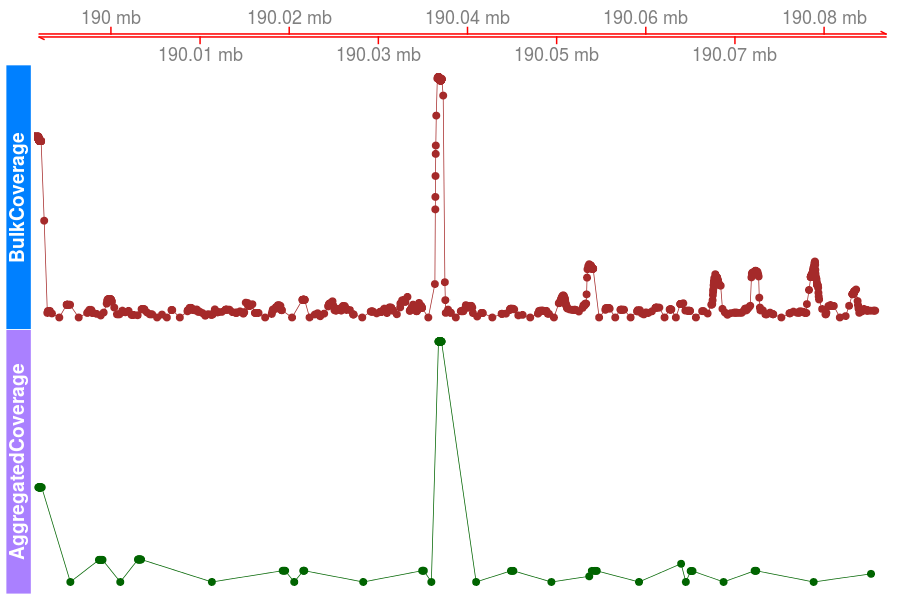

In [32]:
%%R -w 900 -h 600
bamFileBulk <- "/home/baker/my-single-cell-share/Trying_Coverage_R/OE19_Bulk/chr1_bulk.bam"
BulkRead <- readGAlignments(bamFileBulk)
bamFileSingleCellMerge <- "/home/baker/my-single-cell-share/Trying_Coverage_R/OE19_Single-Cell_Aggregated/chr1_SingleCell_Merged.bam"
SingleCellMergeRead <- readGAlignments(bamFileSingleCellMerge)
myImportFun <- function(file, selection){}
bulkDataTrack <- DataTrack(range=bamFileBulk, genome="hg19", type=c("l","p"), name="BulkCoverage", window=-1, showAxis=FALSE, chromosome="chr1", importFunction = myImportFun(bamFileBulk, BulkRead), stream=TRUE, col="brown",  col.baseline="brown", background.title="#0080ff", cex.sampleNames = 1.5, cex.legend = 2.5, fontsize = 16)
singleCellDataTrack <-DataTrack(range=bamFileSingleCellMerge, genome="hg19", type=c("l","p"), name="AggregatedCoverage", window=-1, showAxis=FALSE, chromosome="chr1", importFunction = myImportFun(bamFileSingleCellMerge, SingleCellMergeRead), stream=TRUE, col="darkgreen", col.baseline="darkgreen", background.title="#aa80ff", cex = 1.5,cex.sampleNames = 1.5, cex.legend = 2.5, fontsize = 16)
SingleCellAnnTrack <- AnnotationTrack(range=bamFileSingleCellMerge, genome="hg19", name="Reads", chromosome="chr1", cex = 1.5,cex.sampleNames = 1.5, cex.legend = 2.5)
itrackLoc <- IdeogramTrack(genome = "hg19", chromosome = "chr1",fontsize = 16)
gtrack <- GenomeAxisTrack(col="red")
plotTracks(list(gtrack,bulkDataTrack,singleCellDataTrack), chromosome = "chr1", from = 189991383, to = 190087517,type=c("l","p"), legend=TRUE, fill=c("red","blue"), littleTicks=TRUE, cex = 1.8)
#plotTracks(singleCellDataTrack, chromosome = "chr1", from = 189880083, to = 190087517,type=c("l","p"), legend=TRUE, background.title="#0080ff")

In [44]:
%%R
BulkBed2000 <- AnnotationTrack("/home/baker/my-single-cell-share/Trying_Coverage_R/OE19_top_2000.bed", genome="hg19", name="BulkBed2000")
OverlapAggregateBed2000 <- AnnotationTrack("/home/baker/my-single-cell-share/Trying_Coverage_R/AggregateOverlapping2000.bed", genome="hg19", name="AggregateBed2000")

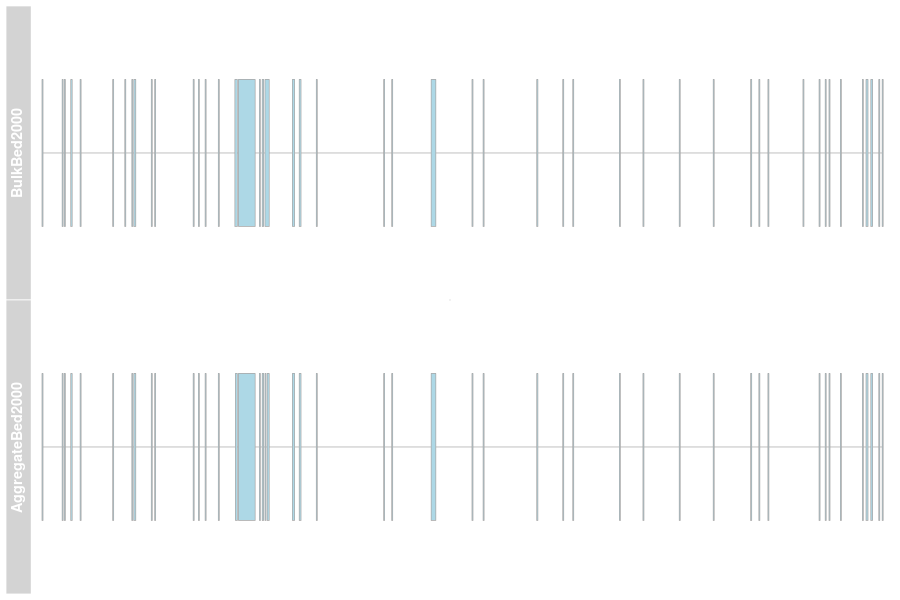

In [45]:
%%R -w 900 -h 600
plotTracks(list(BulkBed2000,OverlapAggregateBed2000))

In [46]:
%%R
Bulk2000Data <- read.table("/home/baker/my-single-cell-share/Trying_Coverage_R/BulkOverlappingCount2000.txt")
Aggr2000Data <- read.table("/home/baker/my-single-cell-share/Trying_Coverage_R/AggregateOverlappingCount2000.txt")

In [ ]:
%%R
head(Bulk2000Data)

In [ ]:
%%R
Logratio2000 <- log2(Bulk2000Data$V11 / Aggr2000Data$V11)

In [ ]:
%%R
Logratio2000

In [ ]:
%%R
plot(log2(Bulk2000Data$V11), log2(Aggr2000Data$V11))

In [ ]:
%%R -w 900
hist(Logratio2000, breaks=100)

__Missing Peaks__

In [ ]:
%%R
Coverage <- c(1000, 2000, 5000, 10000, 20000, 30000, 40000, 50000)
MissingPeaks <- c(19, 66, 359, 1294, 4642, 9440, 15336, 21999)
PercentMissingPeaks <- 100*(MissingPeaks/Coverage)
plot(Coverage, PercentMissingPeaks, type="b", xlab="Top Peaks", ylab="% Missing Peaks")

In [ ]:
%%R
mpg <- data.frame(Coverage,PercentMissingPeaks)
ggplot(mpg, aes(Coverage,PercentMissingPeaks))+geom_point(color="#CC0000", size=3)+geom_line(color="#CC0000")+labs(x="No. of Top Peaks in Bulk", y="% Missing Peaks in Single-cell Aggregated")

In [34]:
%%R
BulkPeak <- read.table("/home/baker/my-single-cell-share/OE19/Macs2/OE19_peaks.narrowPeak")
AggregatedPeak <- read.table("/home/baker/my-scratch-share/Ed_Britton_Single_cell_ATAC_seq_ReRun_Trimmed/output/Merged_Filtered_Macs2_files/OE19_Filtered_peaks.narrowPeak")

In [35]:
%%R -o AggregatedPeak
print(dim(BulkPeak))
print(dim(AggregatedPeak))
print(dim(BulkPeak)[1]/dim(AggregatedPeak)[1])

[1] 112459     10
[1] 69426    10
[1] 1.61984


In [36]:
%%R -o SortBulkPeak,BulkPeak
SortBulkPeak <- BulkPeak
SortBulkPeak <- SortBulkPeak[order(SortBulkPeak$V9,decreasing = TRUE),]
head(SortBulkPeak)

          V1        V2        V3
28657  chr13  50017869  50018877
21050  chr11 105892593 105893543
101379  chr8  94766887  94767417
102249  chr8 110620012 110620497
106852  chr9  99153458  99153990
78126   chr4  83205946  83206515
                                                                              V4
28657  /mnt/fls01-home01/mqbsseba/data/ATAC_UptoDate/OE19/Macs2/OE19_peak_23475a
21050  /mnt/fls01-home01/mqbsseba/data/ATAC_UptoDate/OE19/Macs2/OE19_peak_17253b
101379  /mnt/fls01-home01/mqbsseba/data/ATAC_UptoDate/OE19/Macs2/OE19_peak_83445
102249  /mnt/fls01-home01/mqbsseba/data/ATAC_UptoDate/OE19/Macs2/OE19_peak_84157
106852  /mnt/fls01-home01/mqbsseba/data/ATAC_UptoDate/OE19/Macs2/OE19_peak_87968
78126   /mnt/fls01-home01/mqbsseba/data/ATAC_UptoDate/OE19/Macs2/OE19_peak_64216
         V5 V6       V7       V8       V9 V10
28657  1540  . 17.63855 162.2612 154.0259 420
21050  1513  . 19.05817 159.2294 151.3070 607
101379 1461  . 22.28739 153.3602 146.1552 198
102249 1460  . 20.

In [37]:
%%R -o SortAggregatePeak
SortAggregatePeak <-AggregatedPeak
SortAggregatePeak <- SortAggregatePeak[order(SortAggregatePeak$V9,decreasing = TRUE),]
head(SortAggregatePeak)

         V1       V2       V3
26608 chr17 39809835 39811346
26611 chr17 39811480 39812922
26707 chr17 39941915 39943763
26717 chr17 39956484 39958553
26413 chr17 37830451 37833144
26708 chr17 39941915 39943763
                                                                                                                                           V4
26608 /home/baker/my-scratch-share/Ed_Britton_Single_cell_ATAC_seq_ReRun_Trimmed/output/Merged_Filtered_Macs2_files/OE19_Filtered_peak_25185b
26611 /home/baker/my-scratch-share/Ed_Britton_Single_cell_ATAC_seq_ReRun_Trimmed/output/Merged_Filtered_Macs2_files/OE19_Filtered_peak_25186b
26707 /home/baker/my-scratch-share/Ed_Britton_Single_cell_ATAC_seq_ReRun_Trimmed/output/Merged_Filtered_Macs2_files/OE19_Filtered_peak_25258c
26717 /home/baker/my-scratch-share/Ed_Britton_Single_cell_ATAC_seq_ReRun_Trimmed/output/Merged_Filtered_Macs2_files/OE19_Filtered_peak_25265a
26413 /home/baker/my-scratch-share/Ed_Britton_Single_cell_ATAC_seq_ReRun_Trimmed

In [38]:
SortBulkPeakndArray = np.matrix(SortBulkPeak)
CoverageData = np.zeros(shape = (len(range(500,50000,500)),2))
j=0
for x in range(500,50000,500):
    np.savetxt("BulkInput.in", SortBulkPeakndArray[0:x,:], fmt='%s', delimiter='\t')
    tmpBulkData = np.loadtxt("BulkInput.in", dtype='str')
    os.system('bedtools intersect -v -b /home/baker/my-scratch-share/Ed_Britton_Single_cell_ATAC_seq_ReRun/output/Merged_Filtered_Macs2_files/OE19_Filtered_peaks.narrowPeak -a BulkInput.in -bed > tmpNonOverlapping.txt')
    tmpResultData = np.loadtxt('tmpNonOverlapping.txt', dtype='str')
    CoverageData[j,0] = x
    CoverageData[j,1] = tmpResultData.shape[0]
    j = j + 1    

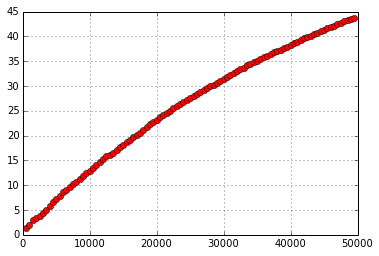

In [39]:
PrcntCoverage = 100*(CoverageData[:,1]/CoverageData[:,0])
plt.plot(CoverageData[:,0],PrcntCoverage, 'ro')
plt.grid(True)


In [41]:
FalseNegative = CoverageData[:,1]

In [40]:
SortAggregatePeakndArray = np.matrix(SortAggregatePeak)

In [14]:
SortAggregatePeakndArray = np.matrix(SortAggregatePeak)
AggregateCoverageData = np.zeros(shape = (len(range(500,50000,500)),2))
j=0
for x in range(500,50000,500):
    np.savetxt("AggregateInput.in", SortAggregatePeakndArray[0:x,:], fmt='%s', delimiter='\t')
    tmpBulkData = np.loadtxt("AggregateInput.in", dtype='str')
    os.system('bedtools intersect -v -a AggregateInput.in -b /home/baker/my-single-cell-share/OE19/Macs2/OE19_peaks.narrowPeak -bed > tmpNonOverlapping.txt')
    tmpResultData = np.loadtxt('tmpNonOverlapping.txt', dtype='str')
    AggregateCoverageData[j,0] = x
    AggregateCoverageData[j,1] = tmpResultData.shape[0]
    j = j + 1   

In [15]:
AggregateCoverageData

array([[  5.00000000e+02,   2.70000000e+01],
       [  1.00000000e+03,   1.10000000e+02],
       [  1.50000000e+03,   2.42000000e+02],
       [  2.00000000e+03,   4.08000000e+02],
       [  2.50000000e+03,   5.60000000e+02],
       [  3.00000000e+03,   7.32000000e+02],
       [  3.50000000e+03,   9.11000000e+02],
       [  4.00000000e+03,   1.09500000e+03],
       [  4.50000000e+03,   1.29000000e+03],
       [  5.00000000e+03,   1.46100000e+03],
       [  5.50000000e+03,   1.67700000e+03],
       [  6.00000000e+03,   1.88200000e+03],
       [  6.50000000e+03,   2.04500000e+03],
       [  7.00000000e+03,   2.24900000e+03],
       [  7.50000000e+03,   2.45000000e+03],
       [  8.00000000e+03,   2.66600000e+03],
       [  8.50000000e+03,   2.85500000e+03],
       [  9.00000000e+03,   3.08800000e+03],
       [  9.50000000e+03,   3.28800000e+03],
       [  1.00000000e+04,   3.52800000e+03],
       [  1.05000000e+04,   3.72400000e+03],
       [  1.10000000e+04,   3.92200000e+03],
       [  

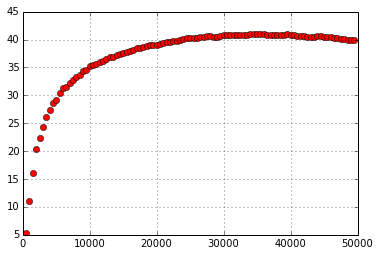

In [16]:
PrcntCoverage = 100*(AggregateCoverageData[:,1]/AggregateCoverageData[:,0])
plt.plot(AggregateCoverageData[:,0],PrcntCoverage, 'ro')
plt.grid(True)

In [17]:
FalsePositive = AggregateCoverageData[:,1]
TruePositive = AggregateCoverageData[:,0] - AggregateCoverageData[:,1]

In [18]:
Recall = (TruePositive/(TruePositive + FalseNegative))
print(Recall)

[ 0.98541667  0.97909791  0.96620584  0.960193    0.95284872  0.94421316
  0.93600868  0.92633929  0.9155733   0.90790149  0.89805027  0.88884092
  0.88305253  0.87624493  0.86829436  0.86226964  0.85478498  0.84662752
  0.84002705  0.83337626  0.82704748  0.8199722   0.81278993  0.80661122
  0.80084746  0.79658385  0.79181395  0.78643553  0.77972659  0.77451955
  0.76962348  0.76469682  0.75914906  0.75421652  0.74918295  0.74344494
  0.73728096  0.73254932  0.72808576  0.72419939  0.71990527  0.71529689
  0.71101143  0.70761448  0.70318973  0.69977802  0.69527094  0.69161936
  0.68798422  0.68466156  0.68185069  0.67808817  0.6748558   0.67146082
  0.66797482  0.66484153  0.66288752  0.66026328  0.65665043  0.65319618
  0.65074046  0.64760526  0.64452436  0.64190334  0.6396905   0.63759943
  0.63408473  0.63162528  0.62917529  0.62715982  0.62436306  0.6227708
  0.62119209  0.61914725  0.6169338   0.61503579  0.61305857  0.61095948
  0.6088839   0.60679948  0.60505198  0.60375953  0.

In [19]:
Precision = (TruePositive / (TruePositive + FalsePositive))
print(Precision)

[ 0.946       0.89        0.83866667  0.796       0.776       0.756
  0.73971429  0.72625     0.71333333  0.7078      0.69509091  0.68633333
  0.68538462  0.67871429  0.67333333  0.66675     0.66411765  0.65688889
  0.65389474  0.6472      0.64533333  0.64345455  0.63991304  0.6385
  0.63504     0.63138462  0.63051852  0.62864286  0.62544828  0.62333333
  0.62245161  0.6203125   0.61854545  0.61552941  0.61565714  0.61433333
  0.61178378  0.60978947  0.60953846  0.60945     0.60795122  0.60633333
  0.60455814  0.60404545  0.60355556  0.60308696  0.60059574  0.599
  0.59804082  0.5976      0.59815686  0.5975      0.59603774  0.59481481
  0.59418182  0.59410714  0.59494737  0.59496552  0.59410169  0.59266667
  0.59213115  0.59145161  0.59171429  0.591875    0.59270769  0.59269697
  0.59197015  0.59094118  0.5902029   0.59008571  0.59022535  0.59075
  0.59219178  0.59183784  0.59224     0.59247368  0.5918961   0.59120513
  0.59098734  0.591675    0.59202469  0.59302439  0.59366265  0.5945

[0.5, 1, 0.5, 1]

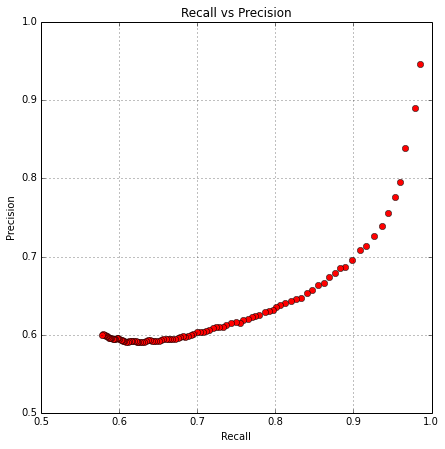

In [20]:
plt.figure(figsize=(7,7))
plt.plot(Recall,Precision, 'ro',label="Recall")
plt.grid(True)
plt.title("Recall vs Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0.5,1,0.5,1])

In [ ]:
?plt.plot

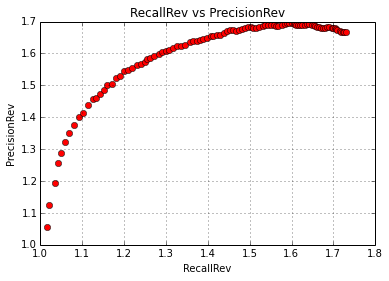

In [21]:
RecallRev = ((TruePositive + FalseNegative)/TruePositive)
PrecisionRev = ((TruePositive + FalsePositive)/TruePositive )
plt.plot(RecallRev,PrecisionRev, 'ro',label="Recall")
plt.grid(True)
plt.title("RecallRev vs PrecisionRev")
plt.xlabel("RecallRev")
plt.ylabel("PrecisionRev")

In [42]:
print(SortAggregatePeakndArray.shape[0])
BulkPeakndArray = np.matrix(BulkPeak)

69426


We set a cut-off in `SortAggregatePeakndArray` to select the positive and negative ones. The `-log10(q-value)` cutoff was 10. The index for this cutoff is `26181`.

In [43]:
AggregatePositive = SortAggregatePeakndArray[0:40000,]
AggregateNegative = SortAggregatePeakndArray[40001:SortAggregatePeakndArray.shape[0],]
AggregateNegative.sort(axis=-2)
print(AggregateNegative.shape)

(29425, 10)


In [24]:
AggregateCoverageData = np.zeros(shape = (len(range(500,25000,500)),2))
j=0
for x in range(500,25000,500):
    np.savetxt("AggregateInput.in", AggregatePositive[0:x,:], fmt='%s', delimiter='\t')
    tmpBulkData = np.loadtxt("AggregateInput.in", dtype='str')
    os.system('bedtools intersect -v -a AggregateInput.in -b /home/baker/my-single-cell-share/OE19/Macs2/OE19_peaks.narrowPeak -bed > tmpNonOverlapping.txt')
    tmpResultData = np.loadtxt('tmpNonOverlapping.txt', dtype='str')
    AggregateCoverageData[j,0] = x
    AggregateCoverageData[j,1] = tmpResultData.shape[0]
    j = j + 1 

In [25]:
#FN = AggregateCoverageData[:,1]
FP = AggregateCoverageData[:,1]
TP = AggregateCoverageData[:,0] - AggregateCoverageData[:,1]

In [26]:
AggregateCoverageData = np.zeros(shape = (len(range(500,25000,500)),2))
j=0
for x in range(500,25000,500):
    np.savetxt("AggregateInput.in", AggregateNegative[0:x,:], fmt='%s', delimiter='\t')
    tmpBulkData = np.loadtxt("AggregateInput.in", dtype='str')
    os.system('bedtools intersect -v -a AggregateInput.in -b /home/baker/my-single-cell-share/OE19/Macs2/OE19_peaks.narrowPeak -bed > tmpNonOverlapping.txt')
    tmpResultData = np.loadtxt('tmpNonOverlapping.txt', dtype='str')
    AggregateCoverageData[j,0] = x
    AggregateCoverageData[j,1] = tmpResultData.shape[0]
    j = j + 1 

In [27]:
#FP = AggregateCoverageData[:,1]
TN = AggregateCoverageData[:,1]
FN = AggregateCoverageData[:,0] - AggregateCoverageData[:,1]

In [28]:
print(TP)
print(TN)
print(FP)
print(FN)

[   473.    890.   1258.   1592.   1940.   2268.   2589.   2905.   3210.
   3539.   3823.   4118.   4455.   4751.   5050.   5334.   5645.   5912.
   6212.   6472.   6776.   7078.   7359.   7662.   7938.   8208.   8512.
   8801.   9069.   9350.   9648.   9925.  10206.  10464.  10774.  11058.
  11318.  11586.  11886.  12189.  12463.  12733.  12998.  13289.  13580.
  13871.  14114.  14376.  14652.]
[   458.    911.   1370.   1832.   2297.   2769.   3254.   3731.   4206.
   4690.   5177.   5660.   6145.   6607.   7091.   7567.   8051.   8511.
   8983.   9483.   9955.  10407.  10855.  11351.  11820.  12270.  12731.
  13202.  13659.  14128.  14591.  15091.  15591.  16091.  16590.  17076.
  17571.  18059.  18552.  19031.  19501.  19986.  20474.  20952.  21420.
  21908.  22388.  22856.  23340.]
[   27.   110.   242.   408.   560.   732.   911.  1095.  1290.  1461.
  1677.  1882.  2045.  2249.  2450.  2666.  2855.  3088.  3288.  3528.
  3724.  3922.  4141.  4338.  4562.  4792.  4988.  5199.  54

In [29]:
Recall = (TP/(TP + FN))
Precision = (TP / (TP + FP))
print(Recall)
print(Precision)

[ 0.9184466   0.90909091  0.90634006  0.90454545  0.90527298  0.90756303
  0.91322751  0.9152489   0.91609589  0.9194596   0.92209358  0.92373262
  0.92619543  0.92360031  0.92507785  0.92491763  0.92632097  0.92360569
  0.92316838  0.92602661  0.92555662  0.92269587  0.91941529  0.92191072
  0.92109538  0.91832625  0.91714255  0.91686634  0.91513623  0.9146938
  0.91389599  0.91609747  0.91821862  0.92007386  0.92211571  0.92288433
  0.92414469  0.92488225  0.92613371  0.92635659  0.92579112  0.92623845
  0.9268397   0.92690242  0.92633015  0.92701998  0.92696703  0.92628866
  0.926638  ]
[ 0.946       0.89        0.83866667  0.796       0.776       0.756
  0.73971429  0.72625     0.71333333  0.7078      0.69509091  0.68633333
  0.68538462  0.67871429  0.67333333  0.66675     0.66411765  0.65688889
  0.65389474  0.6472      0.64533333  0.64345455  0.63991304  0.6385
  0.63504     0.63138462  0.63051852  0.62864286  0.62544828  0.62333333
  0.62245161  0.6203125   0.61854545  0.6155294

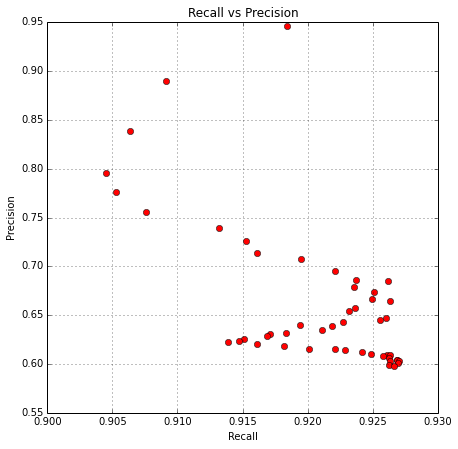

In [30]:
plt.figure(figsize=(7,7))
plt.plot(Recall,Precision, 'ro',label="Recall")
plt.grid(True)
plt.title("Recall vs Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
#plt.axis([0.5,1,0.5,1])

In [31]:
TPR = Recall
FPR = FP/(TN+FP)

In [32]:
min(TPR)

0.90454545454545454

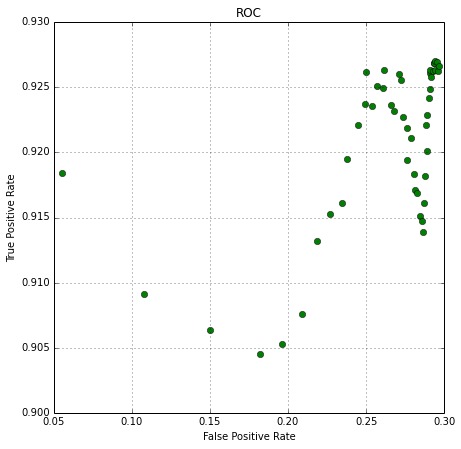

In [33]:
plt.figure(figsize=(7,7))
plt.plot(FPR,TPR, 'go')
#plt.plot(np.linspace(min(FPR), max(FPR), 100),np.linspace(min(TPR), max(TPR), 100), 'r')
plt.grid(True)
plt.title("ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.axis([min(FPR)-0.01, max(FPR),min(TPR), max(TPR)+0.01])

In [34]:
AggregateCoverageData = np.zeros(shape = (len(range(500,25000,500)),2))
AggregateNegCoverageData = np.zeros(shape = (len(range(500,25000,500)),3))
j=0
for x in range(500,25000,500):
    np.savetxt("AggregateInput.in", AggregatePositive[0:x,:], fmt='%s', delimiter='\t')
    tmpBulkData = np.loadtxt("AggregateInput.in", dtype='str')
    os.system('bedtools intersect -v -a AggregateInput.in -b /home/baker/my-single-cell-share/OE19/Macs2/OE19_peaks.narrowPeak -bed > tmpNonOverlapping.txt')
    tmpResultData = np.loadtxt('tmpNonOverlapping.txt', dtype='str')
    AggregateCoverageData[j,0] = x
    AggregateCoverageData[j,1] = tmpResultData.shape[0]
    
    np.savetxt("AggregateInput.in", AggregatePositive[x:SortAggregatePeakndArray.shape[0],:], fmt='%s', delimiter='\t')
    tmpBulkData = np.loadtxt("AggregateInput.in", dtype='str')
    os.system('bedtools intersect -v -a AggregateInput.in -b /home/baker/my-single-cell-share/OE19/Macs2/OE19_peaks.narrowPeak -bed > tmpNonOverlapping.txt')
    tmpResultData = np.loadtxt('tmpNonOverlapping.txt', dtype='str')
    AggregateNegCoverageData[j,0] = len(range(x,SortAggregatePeakndArray.shape[0],1))
    AggregateNegCoverageData[j,1] = x
    AggregateNegCoverageData[j,2] = tmpResultData.shape[0]    
    
    j = j + 1 

In [35]:
TN = AggregateNegCoverageData[:,2]
FN = AggregateNegCoverageData[:,0] - AggregateNegCoverageData[:,2]
FP = AggregateCoverageData[:,1]
TP = AggregateCoverageData[:,0] - AggregateCoverageData[:,1]

In [36]:
Recall = (TP/(TP + FN))
Precision = (TP / (TP + FP))
print(Recall)
print(Precision)

[ 0.0089089   0.01676304  0.02369427  0.02998512  0.03653966  0.0427175
  0.04876349  0.05471531  0.06045995  0.06665662  0.07200573  0.07756201
  0.08390937  0.08948449  0.09511612  0.10046522  0.10632287  0.11135178
  0.11700224  0.12189931  0.12762511  0.13331324  0.13860584  0.14431281
  0.14951124  0.15459665  0.16032245  0.16576573  0.17081348  0.17610608
  0.18171887  0.18693613  0.19222873  0.19708813  0.20292694  0.20827604
  0.21317311  0.21822086  0.22387132  0.22957829  0.23473904  0.23982446
  0.2448157   0.25029665  0.2557776   0.26125855  0.26583542  0.27077016
  0.27596858]
[ 0.946       0.89        0.83866667  0.796       0.776       0.756
  0.73971429  0.72625     0.71333333  0.7078      0.69509091  0.68633333
  0.68538462  0.67871429  0.67333333  0.66675     0.66411765  0.65688889
  0.65389474  0.6472      0.64533333  0.64345455  0.63991304  0.6385
  0.63504     0.63138462  0.63051852  0.62864286  0.62544828  0.62333333
  0.62245161  0.6203125   0.61854545  0.6155294

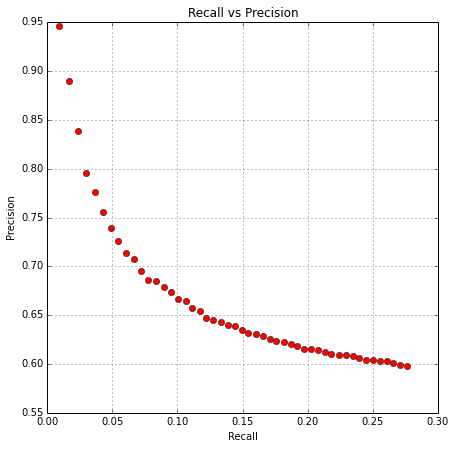

In [37]:
plt.figure(figsize=(7,7))
plt.plot(Recall,Precision, 'ro',label="Recall")
plt.grid(True)
plt.title("Recall vs Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
#plt.axis([0.5,1,0.5,1])

In [45]:
AggregateCoverageData = np.zeros(shape = (len(range(100,25000,100)),2))
AggregateNegCoverageData = np.zeros(shape = (len(range(100,25000,100)),3))
j=0
for x in range(100,25000,100):
    np.savetxt("AggregateInput.in", AggregatePositive[0:x,:], fmt='%s', delimiter='\t')
    tmpBulkData = np.loadtxt("AggregateInput.in", dtype='str')
    os.system('bedtools intersect -v -a AggregateInput.in -b /home/baker/my-single-cell-share/OE19/Macs2/OE19_peaks.narrowPeak -bed > tmpNonOverlapping.txt')
    tmpResultData = np.loadtxt('tmpNonOverlapping.txt', dtype='str')
    AggregateCoverageData[j,0] = x
    AggregateCoverageData[j,1] = tmpResultData.shape[0]
    
    np.savetxt("AggregateInput.in", AggregatePositive[x:SortAggregatePeakndArray.shape[0],:], fmt='%s', delimiter='\t')
    tmpBulkData = np.loadtxt("AggregateInput.in", dtype='str')
    os.system('bedtools intersect -v -a AggregateInput.in -b /home/baker/my-single-cell-share/OE19/Macs2/OE19_peaks.narrowPeak -bed > tmpNonOverlapping.txt')
    tmpResultData = np.loadtxt('tmpNonOverlapping.txt', dtype='str')
    AggregateNegCoverageData[j,0] = len(range(x,SortAggregatePeakndArray.shape[0],1))
    AggregateNegCoverageData[j,1] = x
    AggregateNegCoverageData[j,2] = tmpResultData.shape[0]    
    
    j = j + 1 

In [46]:
TN = AggregateNegCoverageData[:,2]
FN = AggregateNegCoverageData[:,0] - AggregateNegCoverageData[:,2]
FP = AggregateCoverageData[:,1]
TP = AggregateCoverageData[:,0] - AggregateCoverageData[:,1]

In [47]:
Recall = 100*(TP/(TP + FN))
Precision = 100*(TP / (TP + FP))
print(Recall)
print(Precision)

[  0.18269828   0.35597913   0.53114347   0.71195826   0.89088957
   1.05851996   1.21296593   1.37871282   1.52750833   1.67630384
   1.8175654    1.95882696   2.09443806   2.23381613   2.36942723
   2.4937374    2.62181455   2.74800821   2.88173582   2.99851204
   3.12282222   3.25843332   3.38462698   3.52023807   3.65396568
   3.76885842   3.89505208   4.04008061   4.15308986   4.27174957
   4.40924416   4.53167084   4.63714614   4.75392236   4.87634905
   5.00065922   5.11366847   5.22479423   5.3491044    5.47153109
   5.560055     5.68248168   5.80302488   5.93110203   6.04599476
   6.16277099   6.27766372   6.39820692   6.52063361   6.66566214
   6.79373929   6.88791366   6.99527245   7.09321379   7.20057258
   7.31169834   7.43600851   7.55278474   7.6337747    7.75620138
   7.87862807   7.99540429   8.12536493   8.264743     8.39093666
   8.50017893   8.59812028   8.70924604   8.82790575   8.94844895
   9.05580773   9.18576837   9.30254459   9.4212043    9.5116117
   9.628387

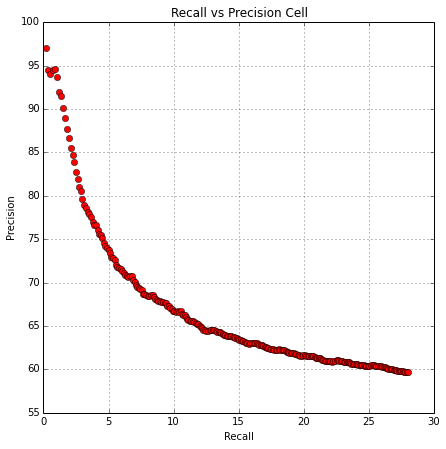

In [48]:
plt.figure(figsize=(7,7))
plt.plot(Recall,Precision, 'ro',label="Recall")
plt.grid(True)
plt.title("Recall vs Precision Cell")
plt.xlabel("Recall")
plt.ylabel("Precision")
#plt.axis([0.5,1,0.5,1])

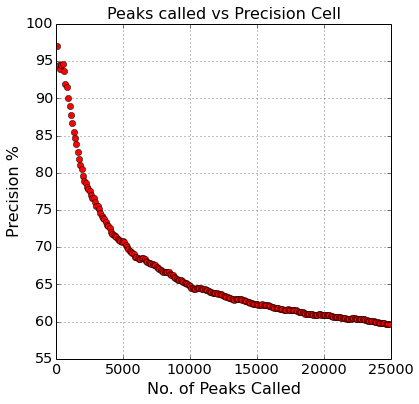

In [53]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
#plt.figure(figsize=(7,7))
plt.plot(AggregateCoverageData[:,0],Precision, 'ro',label="Recall")
plt.grid(True)
plt.title("Peaks called vs Precision Cell", fontsize=16)
plt.xlabel("No. of Peaks Called", fontsize=16)
plt.ylabel("Precision %", fontsize=16)
#plt.axis([0.5,1,0.5,1])

## Calculating precision for OE19 Nuclei data

In [47]:
%%R
AggregatedPeakNuclei <- read.table("/home/baker/my-scratch-share/Conor_Rogerson_Single_cell_ATAC_seq_ReRun_Trimmed/output/Merged_Filtered_Macs2_files/OE19_Filtered_peaks.narrowPeak")
print(dim(AggregatedPeakNuclei))

[1] 71100    10


In [49]:
%%R -o SortAggregatedPeakNuclei
SortAggregatedPeakNuclei <-AggregatedPeakNuclei
SortAggregatedPeakNuclei <- SortAggregatedPeakNuclei[order(SortAggregatedPeakNuclei$V9,decreasing = TRUE),]
head(SortAggregatedPeakNuclei)

         V1       V2       V3
26565 chr17 39811463 39812897
26742 chr17 39956382 39960124
26730 chr17 39941893 39943779
26296 chr17 37830622 37833161
26562 chr17 39809800 39811327
26707 chr17 39928009 39930533
                                                                                                                                               V4
26565 /home/baker/my-scratch-share/Conor_Rogerson_Single_cell_ATAC_seq_ReRun_Trimmed/output/Merged_Filtered_Macs2_files/OE19_Filtered_peak_25575b
26742 /home/baker/my-scratch-share/Conor_Rogerson_Single_cell_ATAC_seq_ReRun_Trimmed/output/Merged_Filtered_Macs2_files/OE19_Filtered_peak_25688a
26730 /home/baker/my-scratch-share/Conor_Rogerson_Single_cell_ATAC_seq_ReRun_Trimmed/output/Merged_Filtered_Macs2_files/OE19_Filtered_peak_25679d
26296 /home/baker/my-scratch-share/Conor_Rogerson_Single_cell_ATAC_seq_ReRun_Trimmed/output/Merged_Filtered_Macs2_files/OE19_Filtered_peak_25369b
26562 /home/baker/my-scratch-share/Conor_Rogerson_Single_cel

In [53]:
SortAggregatePeakndArrayNuclei = np.matrix(SortAggregatedPeakNuclei)
print(SortAggregatePeakndArrayNuclei.shape)
print(SortAggregatePeakndArray.shape)

(71100, 10)
(69426, 10)


In [61]:
AggregatePositive = SortAggregatePeakndArrayNuclei[0:40000,]
print(AggregatePositive.shape)

(40000, 10)


In [62]:
AggregateCoverageData = np.zeros(shape = (len(range(100,35000,100)),2))
AggregateNegCoverageData = np.zeros(shape = (len(range(100,35000,100)),3))
j=0
for x in range(100,35000,100):
    np.savetxt("AggregateInput.in", AggregatePositive[0:x,:], fmt='%s', delimiter='\t')
    tmpBulkData = np.loadtxt("AggregateInput.in", dtype='str')
    os.system('bedtools intersect -v -a AggregateInput.in -b /home/baker/my-single-cell-share/OE19/Macs2/OE19_peaks.narrowPeak -bed > tmpNonOverlapping.txt')
    tmpResultData = np.loadtxt('tmpNonOverlapping.txt', dtype='str')
    AggregateCoverageData[j,0] = x
    AggregateCoverageData[j,1] = tmpResultData.shape[0]
    
    np.savetxt("AggregateInput.in", AggregatePositive[x:SortAggregatePeakndArrayNuclei.shape[0],:], fmt='%s', delimiter='\t')
    tmpBulkData = np.loadtxt("AggregateInput.in", dtype='str')
    os.system('bedtools intersect -v -a AggregateInput.in -b /home/baker/my-single-cell-share/OE19/Macs2/OE19_peaks.narrowPeak -bed > tmpNonOverlapping.txt')
    tmpResultData = np.loadtxt('tmpNonOverlapping.txt', dtype='str')
    AggregateNegCoverageData[j,0] = len(range(x,SortAggregatePeakndArrayNuclei.shape[0],1))
    AggregateNegCoverageData[j,1] = x
    AggregateNegCoverageData[j,2] = tmpResultData.shape[0]    
    
    j = j + 1 

In [63]:
TN = AggregateNegCoverageData[:,2]
FN = AggregateNegCoverageData[:,0] - AggregateNegCoverageData[:,2]
FP = AggregateCoverageData[:,1]
TP = AggregateCoverageData[:,0] - AggregateCoverageData[:,1]

In [64]:
Recall = 100*(TP/(TP + FN))
Precision = 100*(TP / (TP + FP))
print(Recall)
print(Precision.shape)

[  0.17513465   0.31825543   0.46137622   0.61014651   0.7589168
   0.90015442   1.03574253   1.15814847   1.29185341   1.42179202
   1.53289895   1.64400588   1.77206132   1.87940191   1.97544349
   2.0696019    2.18635833   2.30311476   2.40668901   2.49519792
   2.61383752   2.70611276   2.79650484   2.90007909   3.01306919
   3.11664344   3.20515235   3.29742759   3.40853452   3.50834244
   3.61003352   3.69477609   3.783285     3.89062559   3.99796618
   4.1034236    4.20134835   4.27667508   4.35576814   4.45369289
   4.54785131   4.63447704   4.7437008    4.84727506   4.93578396
   5.02994238   5.14293247   5.2540394    5.35384731   5.45365523
   5.56476216   5.6984671    5.78885918   5.88113442   5.98470867
   6.12029679   6.2201047    6.31426312   6.41783737   6.52517796
   6.63063538   6.73420963   6.83778389   6.9319423    7.04493239
   7.15980566   7.26902942   7.36695416   7.47429475   7.59293435
   7.71534029   7.80573236   7.90554028   7.98651652   8.10327295
   8.199314

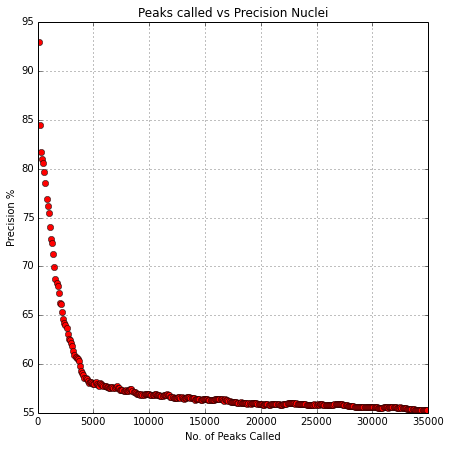

In [66]:
plt.figure(figsize=(7,7))
plt.plot(AggregateCoverageData[:,0],Precision, 'ro',label="Recall")
plt.grid(True)
plt.title("Peaks called vs Precision Nuclei")
plt.xlabel("No. of Peaks Called")
plt.ylabel("Precision %")

## We want to see how BULK data would resemble the figure for OE19

In [10]:
%%R
HET1A_R1 <- read.table("/home/baker/my-single-cell-share/HET1A_R1/Macs2/HET1A_R1_peaks.narrowPeak")
HET1A_R2 <- read.table("/home/baker/my-single-cell-share/HET1A_R2/Macs2/HET1A_R2_peaks.narrowPeak")

In [11]:
%%R
OE33_R1 <- read.table("/home/baker/my-single-cell-share/OE33_R1_peaks.narrowPeak")
OE33_R2 <- read.table("/home/baker/my-single-cell-share/OE33_R2_peaks.narrowPeak")
OE33_R3 <- read.table("/home/baker/my-single-cell-share/OE33_R3_peaks.narrowPeak")

In [12]:
%%R
dim(OE33_R3)

[1] 18019    10


In [13]:
%%R
print(dim(HET1A_R1))
print(dim(HET1A_R2))

[1] 40222    10
[1] 42151    10


The ratio between `OE19Bulk` and `OE19SingleCellAggregated` is `OE19SingleCellAggregated` is 2.04 times lower. So we took the same ratio for `HET1A_R1` and `HET1A_R2`.
We cannot use __OE19__ for this experiment as we do not have any replicates for this.

In [14]:
%%R
dummyHet1a_r2 <- HET1A_R2[1:(dim(HET1A_R1)[1]/2.04),]
dim(dummyHet1a_r2)

[1] 19716    10


In [15]:
%%R -o SortHET1A_R2
SortHET1A_R2 <- dummyHet1a_r2
SortHET1A_R2 <- SortHET1A_R2[order(SortHET1A_R2$V9,decreasing = TRUE),]
head(SortHET1A_R2)
dim(SortHET1A_R2)

[1] 19716    10


In [16]:
SortHET1A_R2Matrix = np.matrix(SortHET1A_R2)

In [17]:
AggregateCoverageData = np.zeros(shape = (len(range(100,19000,100)),2))
AggregateNegCoverageData = np.zeros(shape = (len(range(100,19000,100)),3))
j=0
for x in range(100,19000,100):
    np.savetxt("AggregateInput.in", SortHET1A_R2Matrix[0:x,:], fmt='%s', delimiter='\t')
    tmpBulkData = np.loadtxt("AggregateInput.in", dtype='str')
    os.system('bedtools intersect -v -a AggregateInput.in -b /home/baker/my-single-cell-share/HET1A_R1/Macs2/HET1A_R1_peaks.narrowPeak -bed > tmpNonOverlapping.txt')
    tmpResultData = np.loadtxt('tmpNonOverlapping.txt', dtype='str')
    AggregateCoverageData[j,0] = x
    AggregateCoverageData[j,1] = tmpResultData.shape[0]
    
    np.savetxt("AggregateInput.in", SortHET1A_R2Matrix[x:SortHET1A_R2Matrix.shape[0],:], fmt='%s', delimiter='\t')
    tmpBulkData = np.loadtxt("AggregateInput.in", dtype='str')
    os.system('bedtools intersect -v -a AggregateInput.in -b /home/baker/my-single-cell-share/HET1A_R1/Macs2/HET1A_R1_peaks.narrowPeak -bed > tmpNonOverlapping.txt')
    tmpResultData = np.loadtxt('tmpNonOverlapping.txt', dtype='str')
    AggregateNegCoverageData[j,0] = len(range(x,SortHET1A_R2Matrix.shape[0],1))
    AggregateNegCoverageData[j,1] = x
    AggregateNegCoverageData[j,2] = tmpResultData.shape[0]    
    
    j = j + 1 

In [18]:
TN = AggregateNegCoverageData[:,2]
FN = AggregateNegCoverageData[:,0] - AggregateNegCoverageData[:,2]
FP = AggregateCoverageData[:,1]
TP = AggregateCoverageData[:,0] - AggregateCoverageData[:,1]

In [19]:
Recall = 100*(TP/(TP + FN))
Precision = 100*(TP / (TP + FP))
print(Recall)
print(Precision)

[  0.79971566   1.68828861   2.64583148   3.5336944    4.41267868
   5.3005416    6.17952588   7.04963154   7.92861582   8.79872148
   9.66882713  10.52117553  11.38240256  12.26138684  13.09597798
  13.92169049  14.747403    15.5997514   16.39882802  17.24229779
  18.07688893  18.85820829  19.69279943  20.42084702  21.14889461
  21.97460712  22.75592648  23.59939625  24.42510876  25.1975495
  25.90783983  26.55597976  27.32842049  28.11861849  28.82003019
  29.55695641  30.26724674  31.03080884  31.79437095  32.48690402
  32.99298588  33.46355323  34.14720767  34.86637663  35.55003108
  36.24256415  36.92621859  37.56547989  38.24913433  38.96830329
  39.62532185  40.29121904  40.96599485  41.56974163  41.90712954
  42.49311906  42.96368641  43.50528278  44.20669449  44.83707716
  45.5207316   46.06232798  46.73710379  47.31421469  47.93571873
  48.61937317  49.23199858  49.80023084  50.36846311  50.85678771
  51.53156353  51.99325224  52.35727604  52.83672201  53.16523129
  53.529255

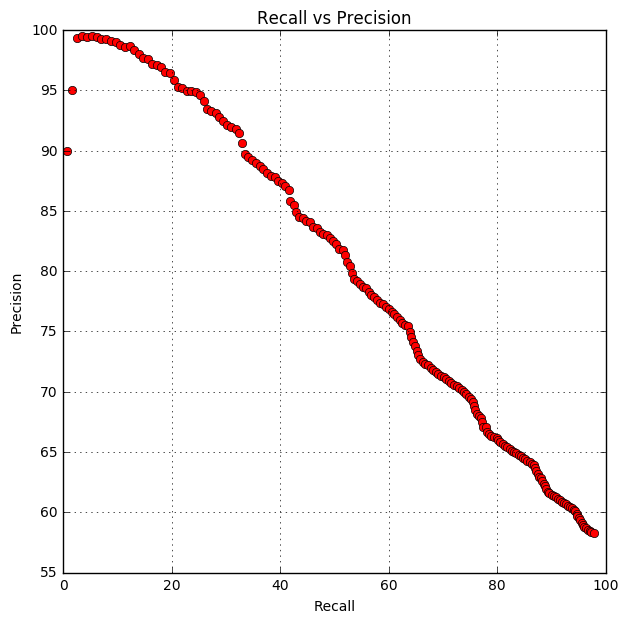

In [20]:
plt.figure(figsize=(7,7))
plt.plot(Recall,Precision, 'ro',label="Recall")
plt.grid(True)
plt.title("Recall vs Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
#plt.axis([0.5,1,0.5,1])

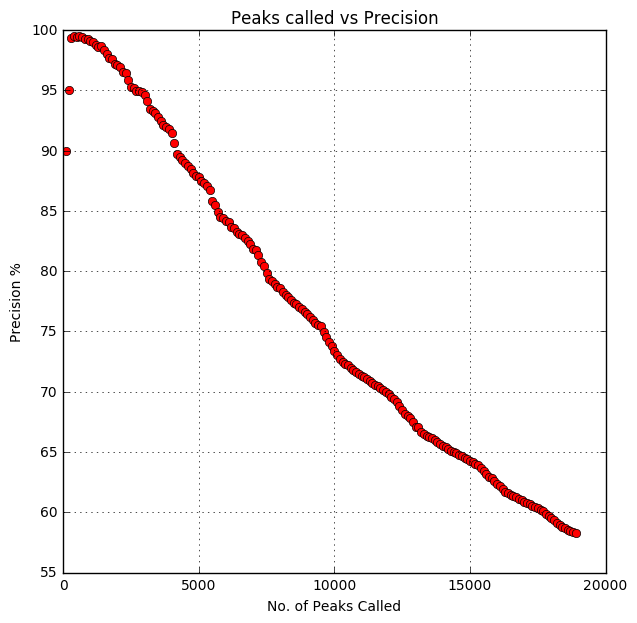

In [21]:
plt.figure(figsize=(7,7))
plt.plot(AggregateCoverageData[:,0],Precision, 'ro',label="Recall")
plt.grid(True)
plt.title("Peaks called vs Precision")
plt.xlabel("No. of Peaks Called")
plt.ylabel("Precision %")
#plt.axis([0.5,1,0.5,1])

## HET1A fastq modification to make it comparable with Single-cell

In [ ]:
root, folders, files = os.walk(intputFolder).next()
files = [os.path.join(root, f) for f in files if (f.endswith('R1_001.fastq.gz'))]
for f in files:
    TempCellName = os.path.basename(f).split('_')
    CellName = TempCellName[0] + '_'+ TempCellName[1]
    # cmdText = 'echo ' + CellName + ' >> ' + outputFolder + 'TotalRead.txt'
    cmdText = 'echo ' + CellName
    subprocess.call(cmdText, shell=True)
    # cmdText = 'zcat ' + f + ' | echo $((`wc -l`/4)) >> '+ outputFolder + 'TotalRead.txt'
    cmdText = 'zcat ' + f + ' | echo $((`wc -l`/4)) '
    subprocess.call(cmdText, shell=True)
    #MergedMacs2Cmd = 'macs2 callpeak -t ' + f +' -n ' + MergedMax2FilePath + CellName + ' -q 0.01 -g hs -f BAM --nomodel --nolambda --shift -75 --extsize 150 -B --SPMR --keep-dup all --call-summits'
    #print MergedMacs2Cmd
    #subprocess.call(MergedMacs2Cmd, shell=True)
    #bgdCmd = bdg2bw_path + ' '+ MergedMax2FilePath + CellName +'_treat_pileup.bdg /home/baker/my-hydra-share/Packages/Homer_4.6/bin/hg19.chrom.sizes'
    #subprocess.call(cmdText, shell=True)
    #print(f)

The average read depth for All single cells were `1156894.417` and the OE19_Bulk read depth were `95493905`. Now taking the ratio, it comes as `82.54` times. Similarly taking the maximum value of the single cell read-depths, the ratio is `23.63` and with the minimum the ratio is `918.47`. Considering all these I took `40` times lower to emmulate the Single-cell Aggregated data from the HET1A cells. I took HET1A_S1 as aggregated and HET1A_S2 as BULK. Now diving HET1A_S1 read depth with `40` we get the read depth as `2234962`. To take out this read we use the command from `seqtk` tool-kit as 
```
seqtk sample -s100 Raw_1_HET1A_R1.fastq.gz 2234962 > Modified_HET1A_S1_R1.fq
seqtk sample -s100 Raw_2_HET1A_R1.fastq.gz 2234962 > Modified_HET1A_S1_R2.fq
```

With division by __40__

In [74]:
%%R
HET1A_R1 <- read.table("/home/baker/my-scratch-share/Dummy_Aggregated/Macs2/Modified_HET1A_nodup_noexclu_sorted_peaks.narrowPeak")
HET1A_R2 <- read.table("/home/baker/my-single-cell-share/HET1A_R2/Macs2/HET1A_R2_peaks.narrowPeak")

In [75]:
%%R
print(dim(HET1A_R1))
print(dim(HET1A_R2))

[1] 3081   10
[1] 42151    10


In [76]:
%%R -o SortHET1A_R1
SortHET1A_R1 <- HET1A_R1
SortHET1A_R1 <- SortHET1A_R1[order(SortHET1A_R1$V9,decreasing = TRUE),]
print(head(SortHET1A_R1))
dim(SortHET1A_R1)

        V1       V2       V3
1087 chr15 81616494 81616767
1161 chr15 93374958 93375294
957  chr15 65903532 65903793
1825 chr20 62313761 62314261
104   chr1 33564911 33565294
1139 chr15 90709013 90709331
                                                      V4  V5 V6       V7
1087 Macs2/Modified_HET1A_nodup_noexclu_sorted_peak_1086 203  . 13.24375
1161 Macs2/Modified_HET1A_nodup_noexclu_sorted_peak_1158 203  . 13.24375
957   Macs2/Modified_HET1A_nodup_noexclu_sorted_peak_956 184  . 12.29776
1825 Macs2/Modified_HET1A_nodup_noexclu_sorted_peak_1822 184  . 12.29776
104   Macs2/Modified_HET1A_nodup_noexclu_sorted_peak_104 165  . 11.35178
1139 Macs2/Modified_HET1A_nodup_noexclu_sorted_peak_1136 165  . 11.35178
           V8       V9 V10
1087 28.37037 20.35705 119
1161 28.37037 20.35705 211
957  25.98077 18.44457 135
1825 25.98077 18.44457 181
104  23.62335 16.58007 154
1139 23.62335 16.58007 200
[1] 3081   10


In [77]:
SortHET1A_R1Matrix = np.matrix(SortHET1A_R1)

In [78]:
AggregateCoverageData = np.zeros(shape = (len(range(100,3000,10)),2))
AggregateNegCoverageData = np.zeros(shape = (len(range(100,3000,10)),3))
j=0
for x in range(100,3000,10):
    np.savetxt("AggregateInput.in", SortHET1A_R1Matrix[0:x,:], fmt='%s', delimiter='\t')
    tmpBulkData = np.loadtxt("AggregateInput.in", dtype='str')
    os.system('bedtools intersect -v -a AggregateInput.in -b /home/baker/my-single-cell-share/HET1A_R2/Macs2/HET1A_R2_peaks.narrowPeak -bed > tmpNonOverlapping.txt')
    tmpResultData = np.loadtxt('tmpNonOverlapping.txt', dtype='str')
    AggregateCoverageData[j,0] = x
    AggregateCoverageData[j,1] = tmpResultData.shape[0]
    
    np.savetxt("AggregateInput.in", SortHET1A_R1Matrix[x:SortHET1A_R1Matrix.shape[0],:], fmt='%s', delimiter='\t')
    tmpBulkData = np.loadtxt("AggregateInput.in", dtype='str')
    os.system('bedtools intersect -v -a AggregateInput.in -b /home/baker/my-single-cell-share/HET1A_R2/Macs2/HET1A_R2_peaks.narrowPeak -bed > tmpNonOverlapping.txt')
    tmpResultData = np.loadtxt('tmpNonOverlapping.txt', dtype='str')
    AggregateNegCoverageData[j,0] = len(range(x,SortHET1A_R1Matrix.shape[0],1))
    AggregateNegCoverageData[j,1] = x
    AggregateNegCoverageData[j,2] = tmpResultData.shape[0]    
    
    j = j + 1 

In [79]:
TN = AggregateNegCoverageData[:,2]
FN = AggregateNegCoverageData[:,0] - AggregateNegCoverageData[:,2]
FP = AggregateCoverageData[:,1]
TP = AggregateCoverageData[:,0] - AggregateCoverageData[:,1]

In [80]:
Recall = 100*(TP/(TP + FN))
Precision = 100*(TP / (TP + FP))
print(Recall)
print(Precision)

[  4.30954588   4.7265987    5.18999073   5.51436515   5.88507878
   6.3021316    6.67284523   7.13623726   7.59962929   8.01668211
   8.38739574   8.75810936   9.22150139   9.59221501  10.00926784
  10.42632067  10.84337349  11.26042632  11.67747915  12.04819277
  12.37256719  12.74328082  13.20667285  13.62372567  13.9944393
  14.36515292  14.78220575  15.19925857  15.6163114   16.03336423
  16.49675626  16.86746988  17.33086191  17.70157553  18.11862836
  18.48934198  18.8137164   19.09175162  19.36978684  19.78683967
  20.20389249  20.62094532  20.94531974  21.40871177  21.68674699
  22.01112141  22.47451344  22.84522706  23.07692308  23.4012975
  23.72567192  24.09638554  24.55977757  24.9304912   25.20852641
  25.48656163  25.76459685  26.08897127  26.5523633   26.83039852
  27.24745134  27.43280816  27.80352178  28.22057461  28.59128823
  29.00834106  29.19369787  29.42539388  29.6107507   29.93512512
  30.16682113  30.49119555  30.90824838  31.278962    31.69601483
  32.0203892

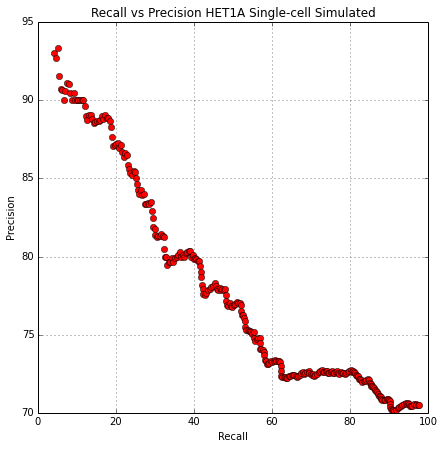

In [81]:
plt.figure(figsize=(7,7))
plt.plot(Recall,Precision, 'ro',label="Recall")
plt.grid(True)
plt.title("Recall vs Precision HET1A Single-cell Simulated")
plt.xlabel("Recall")
plt.ylabel("Precision")
#plt.axis([0.5,1,0.5,1])

## BULK OE19 vs HET1A

In [ ]:
%%R
setwd('/home/baker/Rna-seq_Data-Analysis/Ed_Britton_Single-Cell_ATAC_Seq/')
samples <- read.csv("/home/baker/Rna-seq_Data-Analysis/Ed_Britton_Single-Cell_ATAC_Seq/sampleSheetBulk_OE19_vs_HET1A.csv")
BULK_OE19_HET1A <- dba(sampleSheet = "/home/baker/Rna-seq_Data-Analysis/Ed_Britton_Single-Cell_ATAC_Seq/sampleSheetBulk_OE19_vs_HET1A.csv")
plot(BULK_OE19_HET1A)

In [ ]:
%%R
BULK_OE19_HET1A

In [ ]:
%%R
BULK_OE19_HET1A <- dba.count(BULK_OE19_HET1A, summit=300)

In [ ]:
%%R
plot(BULK_OE19_HET1A)

In [ ]:
%%R
BULK_OE19_HET1A.RawCount <- dba.count(BULK_OE19_HET1A, score=DBA_SCORE_READS)
RawCounts <- dba.peakset(BULK_OE19_HET1A.RawCount, bRetrieve=TRUE, writeFile="/home/baker/my-scratch-share/Ed_Britton_Single_cell_ATAC_seq_ReRun/output/BULK_OE19_HET1A.RawCount.txt")

In [ ]:
%%R
BULK_OE19_HET1A <- dba.contrast(BULK_OE19_HET1A, group1 = BULK_OE19_HET1A$masks$Cancer_Bulk, group2 = BULK_OE19_HET1A$masks$Normal, name1 = "Cancer_Bulk", name2 = "Normal")

In [ ]:
%%R
BULK_OE19_HET1A <- dba.analyze(BULK_OE19_HET1A)

In [ ]:
%%R
plot(BULK_OE19_HET1A, contrast=1)

In [ ]:
%%R
BULK_OE19_HET1A <- dba.peakset(BULK_OE19_HET1A, consensus=DBA_CONDITION,minOverlap=2)
#BULK_OE19_HET1A.OL <- dba.overlap(BULK_OE19_HET1A)

In [ ]:
%%R
BULK_OE19_HET1A

In [ ]:
%%R
BULK_OE19_HET1A.OL <- dba.overlap(BULK_OE19_HET1A, BULK_OE19_HET1A$masks$Cancer_Bulk&BULK_OE19_HET1A$masks$Normal)

In [ ]:
%%R
BULK_OE19_HET1A.DB <- dba.report(BULK_OE19_HET1A)

In [ ]:
%%R
BULK_OE19_HET1A.DB

In [ ]:
%%R
BULK_OE19_HET1A.DB <- dba.report(BULK_OE19_HET1A, file="/home/baker/Rna-seq_Data-Analysis/Ed_Britton_Single-Cell_ATAC_Seq/BULK_OE19_HET1A_Diff_Peaks")

__Retrieve DB sites with p-value <  0.05 and Upregulated by 3 fold

In [ ]:
%%R
BULK_OE19_HET1A.DB.Fold <- dba.report(BULK_OE19_HET1A, th=.05, bUsePval=TRUE)
BULK_OE19_HET1A.DB.Fold <- BULK_OE19_HET1A.DB.Fold[BULK_OE19_HET1A.DB.Fold$Fold>3,]

In [ ]:
%%R
df <- data.frame(seqnames=seqnames(BULK_OE19_HET1A.DB.Fold),
  starts=start(BULK_OE19_HET1A.DB.Fold)-1,
  ends=end(BULK_OE19_HET1A.DB.Fold),
  names=c(rep(".", length(BULK_OE19_HET1A.DB.Fold))),
  scores=c(rep(".", length(BULK_OE19_HET1A.DB.Fold))),
  strands=strand(BULK_OE19_HET1A.DB.Fold),
  fold=BULK_OE19_HET1A.DB.Fold$Fold,
  pvalue=c(rep(".", length(BULK_OE19_HET1A.DB.Fold))),
  FDR=-log10(BULK_OE19_HET1A.DB.Fold$FDR),
  summitPos=c(rep(".", length(BULK_OE19_HET1A.DB.Fold)))) 

# The fold incresae in 3 FOLD, BE CAREFUL about the file name
write.table(df, file="Bulk_DE_5_fold_0.05_FDR.bed", quote=F, sep="\t", row.names=F, col.names=F)

In [ ]:
%%R -o Bulk_DE_5_fold
Bulk_DE_5_fold <- read.table("Bulk_DE_5_fold_0.05_FDR.bed")

In [ ]:
AggregatedPeakPython = np.matrix(AggregatedPeak)
Bulk_DEPython = np.matrix(Bulk_DE_5_fold)

In [ ]:
AggregateCoverageData = np.zeros(shape = (len(range(10,2800,50)),2))
AggregateNegCoverageData = np.zeros(shape = (len(range(10,2800,50)),3))
j=0
for x in range(10,2800,50):
    np.savetxt("AggregateInput.in", Bulk_DEPython[0:x,:], fmt='%s', delimiter='\t')
    tmpBulkData = np.loadtxt("AggregateInput.in", dtype='str')
    os.system('bedtools intersect -v -a AggregateInput.in -b /home/baker/my-scratch-share/Ed_Britton_Single_cell_ATAC_seq_ReRun_Trimmed/output/Merged_Filtered_Macs2_files/OE19_Filtered_peaks.narrowPeak -bed > tmpNonOverlapping.txt')
    tmpResultData = np.loadtxt('tmpNonOverlapping.txt', dtype='str')
    AggregateCoverageData[j,0] = x
    AggregateCoverageData[j,1] = tmpResultData.shape[0]
    
    np.savetxt("AggregateInput.in", Bulk_DEPython[x:Bulk_DEPython.shape[0],:], fmt='%s', delimiter='\t')
    tmpBulkData = np.loadtxt("AggregateInput.in", dtype='str')
    os.system('bedtools intersect -v -a AggregateInput.in -b /home/baker/my-scratch-share/Ed_Britton_Single_cell_ATAC_seq_ReRun_Trimmed/output/Merged_Filtered_Macs2_files/OE19_Filtered_peaks.narrowPeak -bed > tmpNonOverlapping.txt')
    tmpResultData = np.loadtxt('tmpNonOverlapping.txt', dtype='str')
    AggregateNegCoverageData[j,0] = len(range(x,Bulk_DEPython.shape[0],1))
    AggregateNegCoverageData[j,1] = x
    AggregateNegCoverageData[j,2] = tmpResultData.shape[0]    
    
    j = j + 1 

In [ ]:
TN = AggregateNegCoverageData[:,2]
FN = AggregateNegCoverageData[:,0] - AggregateNegCoverageData[:,2]
FP = AggregateCoverageData[:,1]
TP = AggregateCoverageData[:,0] - AggregateCoverageData[:,1]

In [ ]:
Recall = 100*(TP/(TP + FN))
Precision = 100*(TP / (TP + FP))
print(Recall)
print(Precision)

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(Recall,Precision, 'ro',label="Recall")
plt.grid(True)
plt.title("Recall vs Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
#plt.axis([0.5,1,0.5,1])

Now I will try to see how the single-cells represent for the selected peaks with 3 fold DE in BULK

In [ ]:
TN = np.zeros(shape = (len(range(10,2800,50)),96))
FN = np.zeros(shape = (len(range(10,2800,50)),96))
FP = np.zeros(shape = (len(range(10,2800,50)),96))
TP = np.zeros(shape = (len(range(10,2800,50)),96))
Recall = np.zeros(shape = (len(range(10,2800,50)),96))
Precision = np.zeros(shape = (len(range(10,2800,50)),96))

In [ ]:
Bulk_DEPython[1,:]

In [ ]:
plt.figure(figsize=(8,8))
MacsFiles = outputFolder + 'Macs2_files/'
root, folders, files = os.walk(MacsFiles).next()
files = [os.path.join(root, f) for f in files if f.endswith('.narrowPeak')]
files = sorted(files)
CellIndex = 0
for f in files:
    AggregateCoverageData = np.zeros(shape = (len(range(10,2800,50)),2))
    AggregateNegCoverageData = np.zeros(shape = (len(range(10,2800,50)),3))
    j=0
    for x in range(10,2800,50):
        np.savetxt("AggregateInput.in", Bulk_DEPython[0:x,:], fmt='%s', delimiter='\t')
        tmpBulkData = np.loadtxt("AggregateInput.in", dtype='str')
        bedToolCmd = 'bedtools intersect -v -a AggregateInput.in -b ' + f + ' -bed > tmpNonOverlapping.txt'
        #os.system('bedtools intersect -v -a AggregateInput.in -b /home/baker/my-scratch-share/Ed_Britton_Single_cell_ATAC_seq_ReRun_Trimmed/output/Merged_Filtered_Macs2_files/OE19_Filtered_peaks.narrowPeak -bed > tmpNonOverlapping.txt')
        os.system(bedToolCmd)
        #if os.stat("tmpNonOverlapping.txt").st_size > 0:
        tmpResultData = np.loadtxt('tmpNonOverlapping.txt', dtype='str')
        AggregateCoverageData[j,0] = x
        AggregateCoverageData[j,1] = tmpResultData.shape[0]
        #else:
            #print f + 'is broken'
            #break
    
        np.savetxt("AggregateInput.in", Bulk_DEPython[x:Bulk_DEPython.shape[0],:], fmt='%s', delimiter='\t')
        tmpBulkData = np.loadtxt("AggregateInput.in", dtype='str')
        bedToolCmd = 'bedtools intersect -v -a AggregateInput.in -b ' + f + ' -bed > tmpNonOverlapping.txt'
        #os.system('bedtools intersect -v -a AggregateInput.in -b /home/baker/my-scratch-share/Ed_Britton_Single_cell_ATAC_seq_ReRun_Trimmed/output/Merged_Filtered_Macs2_files/OE19_Filtered_peaks.narrowPeak -bed > tmpNonOverlapping.txt')
        os.system(bedToolCmd)
        #if(os.stat("tmpNonOverlapping.txt").st_size > 0):
        tmpResultData = np.loadtxt('tmpNonOverlapping.txt', dtype='str')
        AggregateNegCoverageData[j,0] = len(range(x,Bulk_DEPython.shape[0],1))
        AggregateNegCoverageData[j,1] = x
        AggregateNegCoverageData[j,2] = tmpResultData.shape[0]  
        j = j + 1
        #else:
            #print f + ' is brokern'
            #break
        
    TN[:,CellIndex] = AggregateNegCoverageData[:,2]
    FN[:,CellIndex] = AggregateNegCoverageData[:,0] - AggregateNegCoverageData[:,2]
    FP[:,CellIndex] = AggregateCoverageData[:,1]
    TP[:,CellIndex] = AggregateCoverageData[:,0] - AggregateCoverageData[:,1]
    Recall[:,CellIndex] = 100*(TP[:,CellIndex]/(TP[:,CellIndex] + FN[:,CellIndex]))
    Precision[:,CellIndex] = 100*(TP[:,CellIndex] / (TP[:,CellIndex] + FP[:,CellIndex]))
    #
    plt.plot(Recall,Precision, 'o')
    CellIndex = CellIndex + 1
plt.show()

In [ ]:
TP[0:5,:]

In [ ]:
tmpResultData = np.loadtxt('tmpNonOverlapping.txt', dtype='str')
print(tmpResultData.shape[0])

In [ ]:
 plt.plot(Recall[5:50,7],Precision[5:50,7], 'o')

## BULK vs Aggregated

In [ ]:
%%R
setwd('/home/baker/Rna-seq_Data-Analysis/Ed_Britton_Single-Cell_ATAC_Seq/')
samples <- read.csv("sampleSheetBulkVsAggregated.csv")
OE19BulkPeakVsOE19AggregatePeak <- dba(sampleSheet = "sampleSheetBulkVsAggregated.csv")
plot(OE19BulkPeakVsOE19AggregatePeak)

In [ ]:
%%R
OE19BulkPeakVsOE19AggregatePeak

In [ ]:
%%R
OE19BulkPeakVsOE19AggregatePeak <- dba.count(OE19BulkPeakVsOE19AggregatePeak, summits=300)

In [ ]:
%%R
OE19BulkPeakVsOE19AggregatePeak

In [ ]:
%%R
plot(OE19BulkPeakVsOE19AggregatePeak)

In [ ]:
%%R
OE19BulkPeakVsOE19AggregatePeak <- dba.contrast(OE19BulkPeakVsOE19AggregatePeak, group1=OE19BulkPeakVsOE19AggregatePeak$masks$Cancer_Bulk,group2=OE19BulkPeakVsOE19AggregatePeak$masks$Cancer_Aggregated, name1="Cancer_Bulk", name2="Cancer_Aggregated" )

In [ ]:
%%R
#HET1APeakVSOE19Peak = dba.analyze(HET1APeakVSOE19Peak)
#plot(HET1APeakVSOE19Peak, contrast=1)

OE19BulkPeakVsOE19AggregatePeak = dba.analyze(OE19BulkPeakVsOE19AggregatePeak, method=DBA_EDGER)
plot(OE19BulkPeakVsOE19AggregatePeak, contrast=1)

In [ ]:
%%R
OE19BulkPeakVsOE19AggregatePeak.DB = dba.report(OE19BulkPeakVsOE19AggregatePeak, method=DBA_DESEQ2)

In [ ]:
%%R
OE19BulkPeakVsOE19AggregatePeak.DB

In [ ]:
%%R
names(OE19BulkPeakVsOE19AggregatePeak$masks)

In [ ]:
%%R
dba.overlap(OE19BulkPeakVsOE19AggregatePeak, OE19BulkPeakVsOE19AggregatePeak$masks$Cancer_Bulk & OE19BulkPeakVsOE19AggregatePeak$masks$Cancer_Aggregated)

## Comparing with top 2000 sequences from BULK

First find out the overlapping peaks in Aggregated data with Bulk Data. I used `bedtools intersect` for this

In [ ]:
bedtools intersect -wa -a /home/baker/my-scratch-share/Ed_Britton_Single_cell_ATAC_seq_ReRun/output/Merged_Filtered_Macs2_files/OE19_Filtered_peaks.narrowPeak -b /home/baker/my-single-cell-share/OE19/Macs2/OE19_top_2000.txt -bed > overlapping.txt

Then use `Samtools bedcov` to get the read counts

In [ ]:
samtools bedcov overlapping.txt /home/baker/my-scratch-share/Ed_Britton_Single_cell_ATAC_seq_ReRun/output/Merged_Filtered_BAM/OE19_Filtered_Merged_nodup_sorted.bam > overlappingCount.txt

## Heterogeneity Analysis

In [ ]:
MacsFiles = outputFolder + 'Bam_Files_Filtered_on_Library_Size/'
root, folders, files = os.walk(MacsFiles).next()
files = [os.path.join(root, f) for f in files if f.endswith('.bam')]
files = sorted(files)
for f in files:
    TempCellName = os.path.basename(f).split('_')
    CellName = TempCellName[0] + TempCellName[1]
    #print CellName

In [ ]:
%%R
setwd('/home/baker/Rna-seq_Data-Analysis/Ed_Britton_Single-Cell_ATAC_Seq/')
samples <- read.csv("sampleSheetDiffBindAggregatedVsOE19.csv")
OE19AggregateVsSingleCell <- dba(sampleSheet = "sampleSheetDiffBindAggregatedVsOE19.csv")
plot(OE19AggregateVsSingleCell)

In [ ]:
%%R
OE19AggregateVsSingleCell  <- dba.count(OE19AggregateVsSingleCell , summits=300)
plot(OE19AggregateVsSingleCell)

In [ ]:
%%R
OE19AggregateVsSingleCell <- dba.contrast(OE19AggregateVsSingleCell, group1 = OE19AggregateVsSingleCell$masks$Cancer_Aggregated, group2 = OE19AggregateVsSingleCell$masks$Cancer, name1 = "Cancer_Aggregated", name2 = "Cancer")

In [ ]:
%%R -w 900 -h 900
OE19AggregateVsSingleCell = dba.analyze(OE19AggregateVsSingleCell)
plot(OE19AggregateVsSingleCell, contrast=1)

In [ ]:
%%R -w 900 -h 900
OE19AggregateVsSingleCell.DB = dba.report(OE19AggregateVsSingleCell, bCounts=TRUE)

In [ ]:
%%R -w 900 -h 900
OE19AggregateVsSingleCell.Avail = dba.report(OE19AggregateVsSingleCell, bCalledDetail=TRUE, file='BinaryInformation.csv')

In [ ]:
%%R
OE19AggregateVsSingleCell.DB

In [ ]:
%%R
OE19AggregateVsSingleCell.Avail

In [55]:
%%R
BinaryInformation <- read.csv('DBA_BinaryInformationModified.csv',header=TRUE)

In [56]:
%%R
head(BinaryInformation)

    Chr    Start      End OE19C01 OE19C02 OE19C03 OE19C04 OE19C05 OE19C06
1 chr17 39949218 39949818       -       +       +       +       +       +
2 chr17 37843936 37844536       -       -       +       +       +       +
3 chr17 37834646 37835246       +       +       +       +       +       +
4 chr17 37910394 37910994       +       +       +       +       +       +
5 chr17 39942639 39943239       +       +       +       +       +       +
6 chr17 39811744 39812344       +       +       +       +       +       +
  OE19C07 OE19C08 OE19C09 OE19C10 OE19C11 OE19C12 OE19C13 OE19C14 OE19C15
1       +       +       +       -       +       -       +       -       -
2       -       +       +       +       +       +       -       +       -
3       +       +       +       -       +       +       +       -       -
4       +       +       +       -       +       +       +       -       -
5       +       +       +       +       +       +       +       +       +
6       +       +       +       +     

In [57]:
%%R
BinaryInformationMod <- as.matrix(BinaryInformation)
BinaryInformationMod <- replace(BinaryInformationMod,BinaryInformationMod=='+', 1)
BinaryInformationMod <- replace(BinaryInformationMod,BinaryInformationMod=='-', 0)
BinaryInformationMod <- data.frame(BinaryInformationMod)
head(BinaryInformationMod)
write.csv(BinaryInformationMod, 'BinaryInformation.csv')
BinaryInformation <- read.csv('BinaryInformation.csv', row.names=1)
#BinaryInformationMod[BinaryInformationMod == "+",4:10]
#BinaryInformationMod[BinaryInformationMod == '-',] <- 0

In [58]:
%%R
#BinaryInformation[as.character(BinaryInformation$Chr) == 'chr17',4:5]
chrName <- as.character(unique(BinaryInformation$Chr))
chrSummary <- matrix(,nrow=length(chrName), ncol=length(4:dim(BinaryInformation)[2]))
for(i in 1:length(chrName))
{
    chrSummary[i,] <- colSums(BinaryInformation[as.character(BinaryInformation$Chr) == chrName[i],4:dim(BinaryInformation)[2]])
}
rownames(chrSummary)<-chrName
colnames(chrSummary) <- colnames(BinaryInformation[,4:dim(BinaryInformation)[2]])
    #colSums(BinaryInformation[as.character(BinaryInformation$Chr) == 'chr17',4:dim(BinaryInformation)[2]])

In [59]:
%%R
head(BinaryInformation)

    Chr    Start      End OE19C01 OE19C02 OE19C03 OE19C04 OE19C05 OE19C06
1 chr17 39949218 39949818       0       1       1       1       1       1
2 chr17 37843936 37844536       0       0       1       1       1       1
3 chr17 37834646 37835246       1       1       1       1       1       1
4 chr17 37910394 37910994       1       1       1       1       1       1
5 chr17 39942639 39943239       1       1       1       1       1       1
6 chr17 39811744 39812344       1       1       1       1       1       1
  OE19C07 OE19C08 OE19C09 OE19C10 OE19C11 OE19C12 OE19C13 OE19C14 OE19C15
1       1       1       1       0       1       0       1       0       0
2       0       1       1       1       1       1       0       1       0
3       1       1       1       0       1       1       1       0       0
4       1       1       1       0       1       1       1       0       0
5       1       1       1       1       1       1       1       1       1
6       1       1       1       1     

In [60]:
%%R
BinaryInformationModCluster <- BinaryInformationMod[,4:dim(BinaryInformationMod)[2]]
dim(BinaryInformationModCluster)

[1] 42961    86


In [ ]:
%%R
write.csv(BinaryInformationModCluster,'BinaryInformationModCluster.csv')

In [6]:
%%R
BinaryInformationModCluster <- read.csv('BinaryInformationModCluster.csv', row.names=1)

In [7]:
%%R
head(BinaryInformationModCluster)

  OE19C01 OE19C02 OE19C03 OE19C04 OE19C05 OE19C06 OE19C07 OE19C08 OE19C09
1       0       1       1       1       1       1       1       1       1
2       0       0       1       1       1       1       0       1       1
3       1       1       1       1       1       1       1       1       1
4       1       1       1       1       1       1       1       1       1
5       1       1       1       1       1       1       1       1       1
6       1       1       1       1       1       1       1       1       1
  OE19C10 OE19C11 OE19C12 OE19C13 OE19C14 OE19C15 OE19C16 OE19C18 OE19C19
1       0       1       0       1       0       0       0       1       1
2       1       1       1       0       1       0       1       1       1
3       0       1       1       1       0       0       1       1       1
4       0       1       1       1       0       0       1       1       1
5       1       1       1       1       1       1       1       1       1
6       1       1       1       1     

In [9]:
%%R
dim(BinaryInformationModCluster)

[1] 42961    86


In [8]:
%%R
BinaryInformationModClusterJacard <- jaccard(as.matrix(BinaryInformationModCluster))

In [9]:
%%R
BinaryInformationModClusterJacard

          OE19C01   OE19C02   OE19C03   OE19C04   OE19C05   OE19C06   OE19C07
OE19C01 0.0000000 0.9524887 0.9639831 0.9580420 0.9330855 0.9825432 0.9366391
OE19C02 0.9524887 0.0000000 0.9707352 0.9450000 0.9462572 0.9885529 0.9444444
OE19C03 0.9639831 0.9707352 0.0000000 0.9674149 0.9478320 0.9539205 0.9713640
OE19C04 0.9580420 0.9450000 0.9674149 0.0000000 0.9403579 0.9869595 0.9285714
OE19C05 0.9330855 0.9462572 0.9478320 0.9403579 0.0000000 0.9788351 0.9321267
OE19C06 0.9825432 0.9885529 0.9539205 0.9869595 0.9788351 0.0000000 0.9908463
OE19C07 0.9366391 0.9444444 0.9713640 0.9285714 0.9321267 0.9908463 0.0000000
OE19C08 0.9431818 0.9355828 0.9780635 0.9356913 0.9447005 0.9918713 0.9411765
OE19C09 0.9301205 0.9338422 0.9590344 0.9338624 0.9249493 0.9855596 0.9278997
OE19C10 0.9525547 0.9603175 0.9904306 0.9350649 0.9581006 0.9958042 0.9428571
OE19C11 0.9485359 0.9661319 0.9276511 0.9675090 0.9443522 0.9594235 0.9656160
OE19C12 0.9310345 0.9484848 0.9671254 0.9356913 0.9422633 0.9901

In [15]:
%%R
cov(BinaryInformationModClusterJacard)

              OE19C01       OE19C02       OE19C03       OE19C04       OE19C05
OE19C01  1.111334e-02  4.602834e-04 -2.873349e-04  3.334120e-04  7.992723e-04
OE19C02  4.602834e-04  1.120045e-02 -4.272334e-04  6.806446e-04  5.440515e-04
OE19C03 -2.873349e-04 -4.272334e-04  1.101728e-02 -4.294893e-04  1.132156e-04
OE19C04  3.334120e-04  6.806446e-04 -4.294893e-04  1.123055e-02  6.591346e-04
OE19C05  7.992723e-04  5.440515e-04  1.132156e-04  6.591346e-04  1.103059e-02
OE19C06 -1.583458e-03 -1.706570e-03  4.404170e-04 -1.805149e-03 -1.417590e-03
OE19C07  8.206916e-04  7.118741e-04 -6.216461e-04  1.090325e-03  8.380145e-04
OE19C08  6.918035e-04  9.258522e-04 -7.286833e-04  9.561614e-04  5.704005e-04
OE19C09  9.552727e-04  9.184757e-04 -2.622108e-04  9.237734e-04  1.009488e-03
OE19C10  4.653974e-04  3.785353e-04 -1.051732e-03  1.004030e-03  2.318199e-04
OE19C11  1.148843e-04 -2.612551e-04  8.274549e-04 -3.653197e-04  2.478336e-04
OE19C12  9.660242e-04  6.455167e-04 -5.070754e-04  9.473815e-04 

In [12]:
%%R
write.csv(BinaryInformationModClusterJacard, "OE19_Jacard_distance.csv")

In [14]:
%%R
prcomp(BinaryInformationModClusterJacard)

Standard deviations:
 [1] 4.478396e-01 1.696551e-01 1.347878e-01 1.242498e-01 1.222808e-01
 [6] 1.219707e-01 1.151332e-01 1.124149e-01 1.111906e-01 1.110138e-01
[11] 1.093532e-01 1.086103e-01 1.083858e-01 1.076383e-01 1.072826e-01
[16] 1.066573e-01 1.064553e-01 1.061295e-01 1.057679e-01 1.053912e-01
[21] 1.048877e-01 1.046724e-01 1.045554e-01 1.039511e-01 1.036971e-01
[26] 1.033035e-01 1.028567e-01 1.027901e-01 1.024563e-01 1.022810e-01
[31] 1.022007e-01 1.017542e-01 1.013537e-01 1.012610e-01 1.010366e-01
[36] 1.006860e-01 1.004233e-01 1.001359e-01 9.992437e-02 9.972571e-02
[41] 9.943981e-02 9.918074e-02 9.866339e-02 9.836948e-02 9.818295e-02
[46] 9.808953e-02 9.775863e-02 9.740646e-02 9.722321e-02 9.695737e-02
[51] 9.649587e-02 9.624160e-02 9.607596e-02 9.568145e-02 9.539252e-02
[56] 9.509939e-02 9.502355e-02 9.488883e-02 9.443062e-02 9.380764e-02
[61] 9.352921e-02 9.310926e-02 9.294560e-02 9.253330e-02 9.244680e-02
[66] 9.217395e-02 9.207444e-02 9.123328e-02 9.094766e-02 9.038168e-02

In [65]:
%%R
head(as.matrix(BinaryInformationModCluster))

  OE19C01 OE19C02 OE19C03 OE19C04 OE19C05 OE19C06 OE19C07 OE19C08 OE19C09
1       0       1       1       1       1       1       1       1       1
2       0       0       1       1       1       1       0       1       1
3       1       1       1       1       1       1       1       1       1
4       1       1       1       1       1       1       1       1       1
5       1       1       1       1       1       1       1       1       1
6       1       1       1       1       1       1       1       1       1
  OE19C10 OE19C11 OE19C12 OE19C13 OE19C14 OE19C15 OE19C16 OE19C18 OE19C19
1       0       1       0       1       0       0       0       1       1
2       1       1       1       0       1       0       1       1       1
3       0       1       1       1       0       0       1       1       1
4       0       1       1       1       0       0       1       1       1
5       1       1       1       1       1       1       1       1       1
6       1       1       1       1     

In [66]:
%%R
head(BinaryInformationModClusterJacard)

          OE19C01   OE19C02   OE19C03   OE19C04   OE19C05   OE19C06   OE19C07
OE19C01 0.0000000 0.9524887 0.9639831 0.9580420 0.9330855 0.9825432 0.9366391
OE19C02 0.9524887 0.0000000 0.9707352 0.9450000 0.9462572 0.9885529 0.9444444
OE19C03 0.9639831 0.9707352 0.0000000 0.9674149 0.9478320 0.9539205 0.9713640
OE19C04 0.9580420 0.9450000 0.9674149 0.0000000 0.9403579 0.9869595 0.9285714
OE19C05 0.9330855 0.9462572 0.9478320 0.9403579 0.0000000 0.9788351 0.9321267
OE19C06 0.9825432 0.9885529 0.9539205 0.9869595 0.9788351 0.0000000 0.9908463
          OE19C08   OE19C09   OE19C10   OE19C11   OE19C12   OE19C13   OE19C14
OE19C01 0.9431818 0.9301205 0.9525547 0.9485359 0.9310345 0.9373368 0.9633028
OE19C02 0.9355828 0.9338422 0.9603175 0.9661319 0.9484848 0.9505495 0.9771987
OE19C03 0.9780635 0.9590344 0.9904306 0.9276511 0.9671254 0.9748521 0.9884881
OE19C04 0.9356913 0.9338624 0.9350649 0.9675090 0.9356913 0.9391304 0.9724138
OE19C05 0.9447005 0.9249493 0.9581006 0.9443522 0.9422633 0.9352

In [68]:
%%R
(as.dist(BinaryInformationModClusterJacard))

          OE19C01   OE19C02   OE19C03   OE19C04   OE19C05   OE19C06   OE19C07
OE19C02 0.9524887                                                            
OE19C03 0.9639831 0.9707352                                                  
OE19C04 0.9580420 0.9450000 0.9674149                                        
OE19C05 0.9330855 0.9462572 0.9478320 0.9403579                              
OE19C06 0.9825432 0.9885529 0.9539205 0.9869595 0.9788351                    
OE19C07 0.9366391 0.9444444 0.9713640 0.9285714 0.9321267 0.9908463          
OE19C08 0.9431818 0.9355828 0.9780635 0.9356913 0.9447005 0.9918713 0.9411765
OE19C09 0.9301205 0.9338422 0.9590344 0.9338624 0.9249493 0.9855596 0.9278997
OE19C10 0.9525547 0.9603175 0.9904306 0.9350649 0.9581006 0.9958042 0.9428571
OE19C11 0.9485359 0.9661319 0.9276511 0.9675090 0.9443522 0.9594235 0.9656160
OE19C12 0.9310345 0.9484848 0.9671254 0.9356913 0.9422633 0.9901247 0.9328063
OE19C13 0.9373368 0.9505495 0.9748521 0.9391304 0.9352052 0.9905

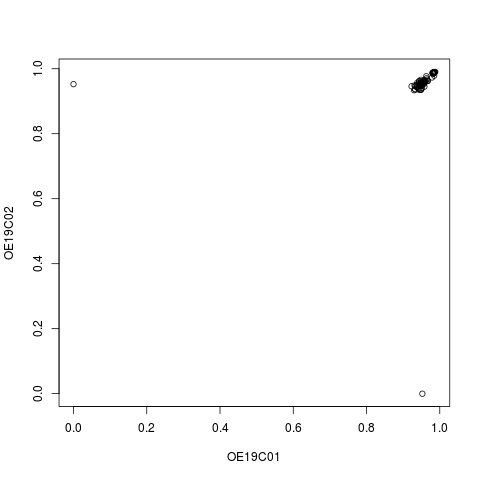

In [67]:
%%R
plot(BinaryInformationModClusterJacard)

[1] "Data (original) range:  0 1"
[1] "Data (scale) range:  -9.1 0.62"
[1] "Data scaled to range:  -3 0.62"
[1] "column"


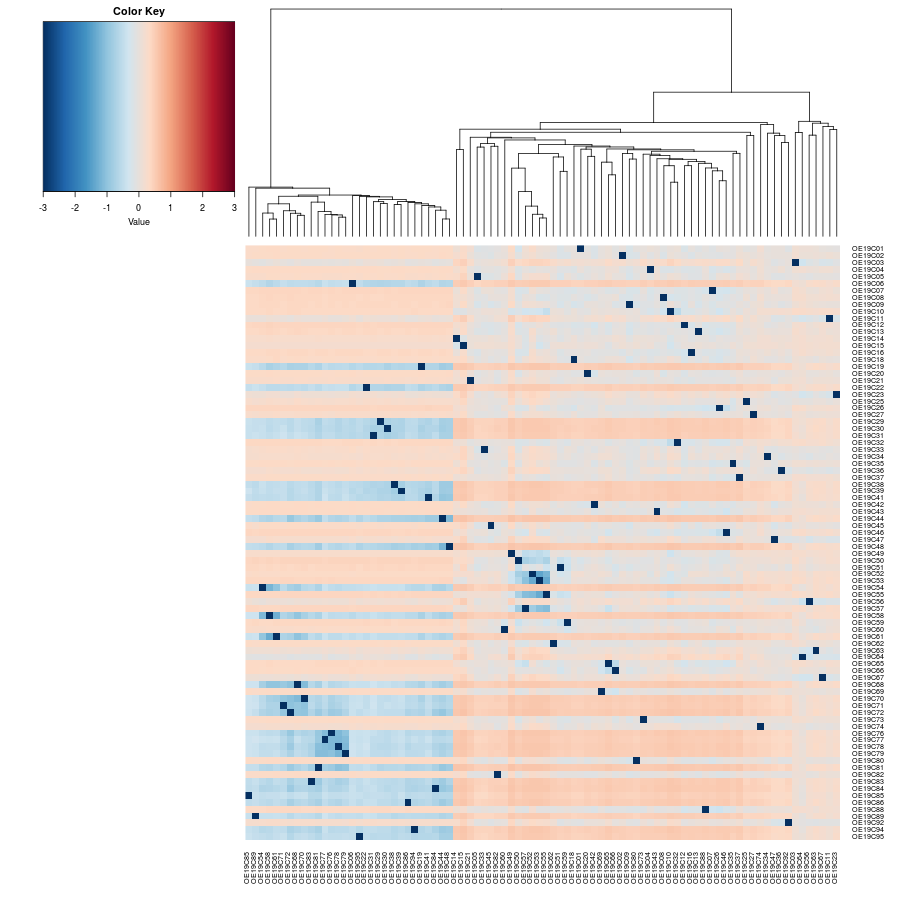

In [17]:
%%R -w 900 -h 900
heatplot(BinaryInformationModClusterJacard, distfun=NULL, scale="none", dend="col")

In [12]:
%%R
dim(BinaryInformationModClusterJacard)

[1] 86 86


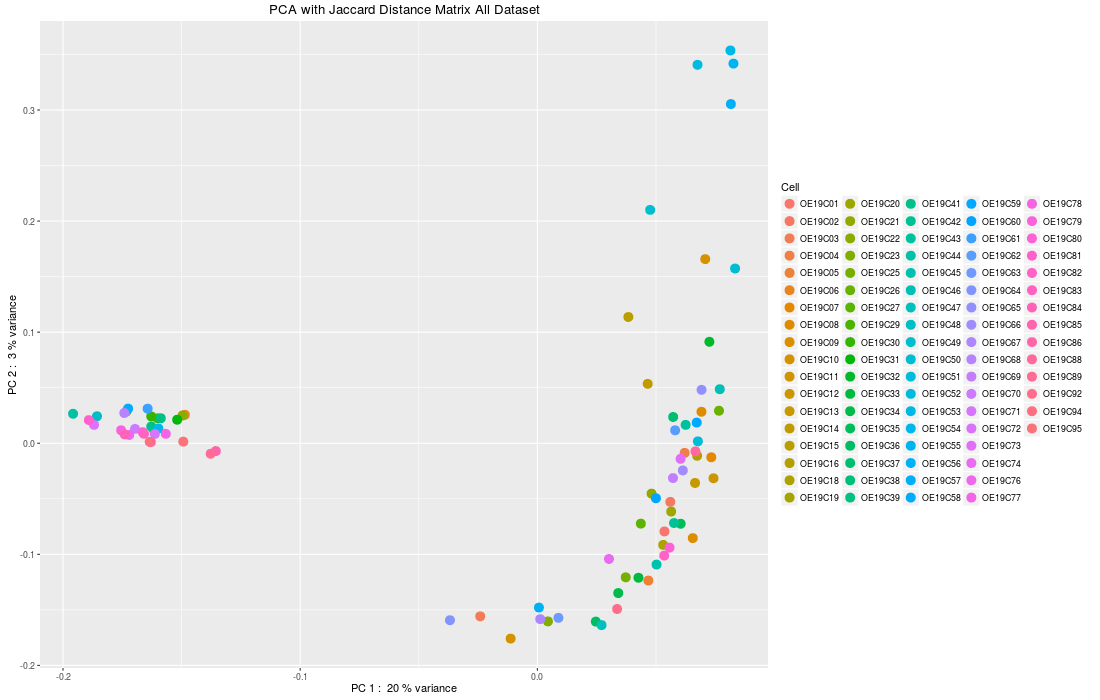

In [13]:
%%R -w 1100 -h 700

#pdf("PCA with Jaccard Distance Matrix All Dataset.pdf") # Used this function to save the file in pdf format
#print(dim(ReadPCAData))
FinalPCAData <- BinaryInformationModClusterJacard
#FinalPCAData <- na.omit(FinalPCAData)
#print(dim(FinalPCAData))
strain <- factor(colnames(BinaryInformationModCluster), levels=colnames(BinaryInformationModCluster), labels=colnames(BinaryInformationModCluster))
PCx=1
PCy=2
pcaPRComp <- prcomp((FinalPCAData))
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$rotation[,PCx],PCY=pcaPRComp$rotation[,PCy], Cell=strain)
p<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p<-p+ggtitle("PCA with Jaccard Distance Matrix All Dataset")
p<-p+geom_point(size = 4)
p<-p+xlab(paste("PC",PCx,": ", ceiling(percentVar[PCx] * 100), "% variance"))
p<-p    + ylab(paste("PC",PCy,": ", ceiling(percentVar[PCy] * 100), "% variance"))
#p<-p + geom_text(data=df,aes(label=colnames(BinaryInformationModClusterJacard)),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45)
print(p)

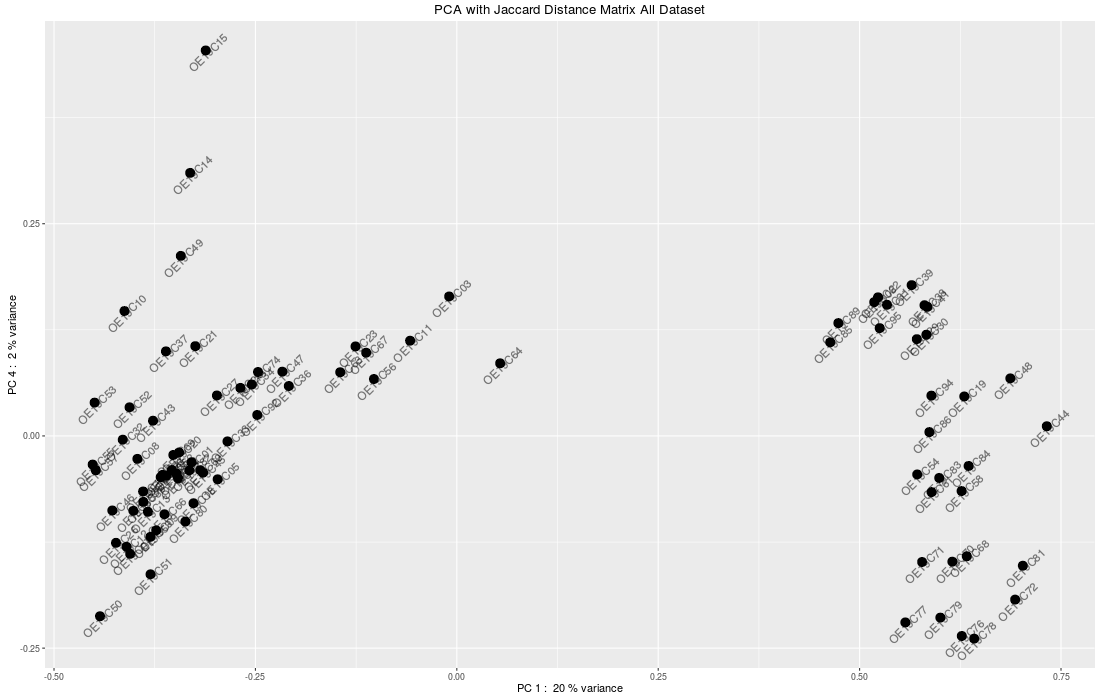

In [17]:
%%R -w 1100 -h 700

#pdf("PCA with Jaccard Distance Matrix All Dataset.pdf") # Used this function to save the file in pdf format
#print(dim(ReadPCAData))
FinalPCAData <- BinaryInformationModClusterJacard
#FinalPCAData <- na.omit(FinalPCAData)
#print(dim(FinalPCAData))
strain <- factor(colnames(BinaryInformationModCluster), levels=colnames(BinaryInformationModCluster), labels=colnames(BinaryInformationModCluster))
PCx=1
PCy=4
pcaPRComp <- prcomp((FinalPCAData))
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy], Cell=strain)
p<-ggplot(df, aes_string(x="PCX",y ="PCY"))
p<-p+ggtitle("PCA with Jaccard Distance Matrix All Dataset")
p<-p+geom_point(size = 4)
p<-p+xlab(paste("PC",PCx,": ", ceiling(percentVar[PCx] * 100), "% variance"))
p<-p    + ylab(paste("PC",PCy,": ", ceiling(percentVar[PCy] * 100), "% variance"))
p<-p + geom_text(data=df,aes(label=colnames(BinaryInformationModClusterJacard)),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45)
print(p)

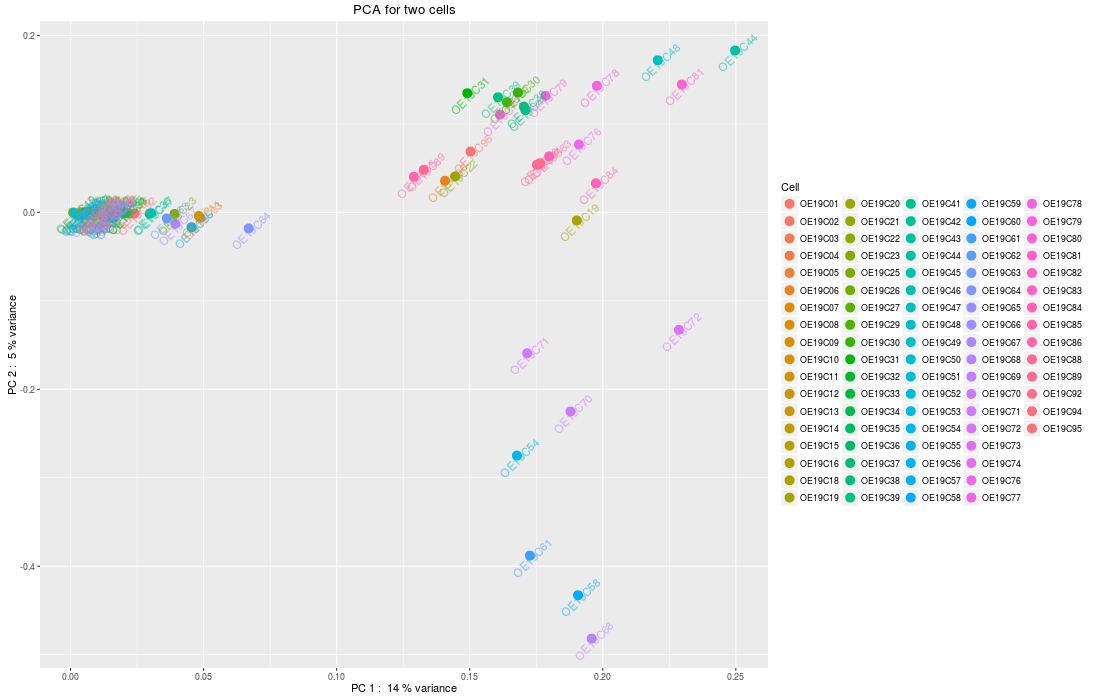

In [14]:
%%R -w 1100 -h 700

#pdf("Cell_Cycle_Normalized_PCA.pdf") # Used this function to save the file in pdf format
#print(dim(ReadPCAData))
FinalPCAData <- data.matrix(BinaryInformationModCluster)
#FinalPCAData <- na.omit(FinalPCAData)
#print(dim(FinalPCAData))
strain <- factor(colnames(BinaryInformationModCluster), levels=colnames(BinaryInformationModCluster), labels=colnames(BinaryInformationModCluster))
PCx=1
PCy=2
pcaPRComp <- prcomp((FinalPCAData))
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$rotation[,PCx],PCY=pcaPRComp$rotation[,PCy],Cell=strain)
p<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p<-p+ggtitle("PCA for two cells")
p<-p+geom_point(size = 4)
p<-p+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p<-p    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
p<-p + geom_text(data=df,aes(label=colnames(data.matrix(BinaryInformationModCluster))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45)
print(p)

In [7]:
%%R
BinaryInformationModClusterJacardSelected <- jaccard(as.matrix(BinaryInformationModCluster[1:5000,]))

In [8]:
%%R
CellZeros <- colSums(as.matrix(BinaryInformationModCluster[1:5000,]) == 0)

In [71]:
%%R
(as.matrix(BinaryInformationModCluster[1:5000,16]))

        [,1]
   [1,]    0
   [2,]    1
   [3,]    1
   [4,]    1
   [5,]    1
   [6,]    1
   [7,]    1
   [8,]    1
   [9,]    1
  [10,]    1
  [11,]    0
  [12,]    1
  [13,]    0
  [14,]    0
  [15,]    1
  [16,]    0
  [17,]    0
  [18,]    1
  [19,]    1
  [20,]    0
  [21,]    0
  [22,]    0
  [23,]    1
  [24,]    0
  [25,]    0
  [26,]    1
  [27,]    0
  [28,]    0
  [29,]    0
  [30,]    0
  [31,]    0
  [32,]    0
  [33,]    1
  [34,]    0
  [35,]    0
  [36,]    0
  [37,]    0
  [38,]    0
  [39,]    0
  [40,]    0
  [41,]    0
  [42,]    0
  [43,]    1
  [44,]    0
  [45,]    1
  [46,]    0
  [47,]    0
  [48,]    0
  [49,]    0
  [50,]    1
  [51,]    1
  [52,]    0
  [53,]    0
  [54,]    0
  [55,]    0
  [56,]    0
  [57,]    0
  [58,]    0
  [59,]    0
  [60,]    0
  [61,]    0
  [62,]    0
  [63,]    0
  [64,]    0
  [65,]    0
  [66,]    0
  [67,]    0
  [68,]    0
  [69,]    0
  [70,]    0
  [71,]    0
  [72,]    0
  [73,]    0
  [74,]    0
  [75,]    0
  [76,]    0

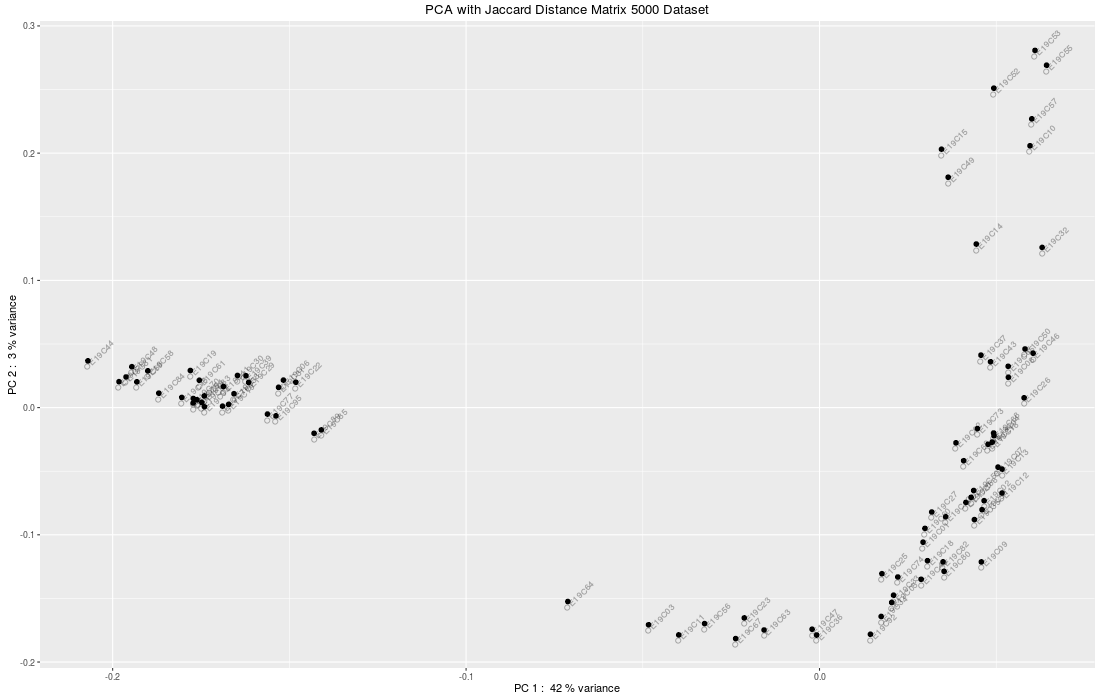

In [72]:
%%R -w 1100 -h 700

#pdf("PCA with Jaccard Distance Matrix 5000 Dataset.pdf") # Used this function to save the file in pdf format
#png("PCA with Jaccard Distance Matrix 5000 Dataset.png") # Used this function to save the file in pdf format
#print(dim(ReadPCAData))
FinalPCAData <- BinaryInformationModClusterJacardSelected
#FinalPCAData <- na.omit(FinalPCAData)
#print(dim(FinalPCAData))
strain <- factor(colnames(BinaryInformationModCluster), levels=colnames(BinaryInformationModCluster), labels=colnames(BinaryInformationModCluster))
PCx=1
PCy=2
pcaPRComp <- prcomp((FinalPCAData))
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$rotation[,PCx],PCY=pcaPRComp$rotation[,PCy], Cell=strain)
p<-ggplot(df, aes_string(x="PCX",y ="PCY"))
p<-p+ggtitle("PCA with Jaccard Distance Matrix 5000 Dataset")
p<-p+geom_point(size = 2)
p<-p+xlab(paste("PC",PCx,": ", ceiling(percentVar[PCx] * 100), "% variance"))
p<-p    + ylab(paste("PC",PCy,": ", ceiling(percentVar[PCy] * 100), "% variance"))
p<-p + geom_text(data=df,aes(label=colnames(BinaryInformationModClusterJacard)),alpha=0.3,size=3, vjust=1,hjust=0.2,angle=45)
print(p)

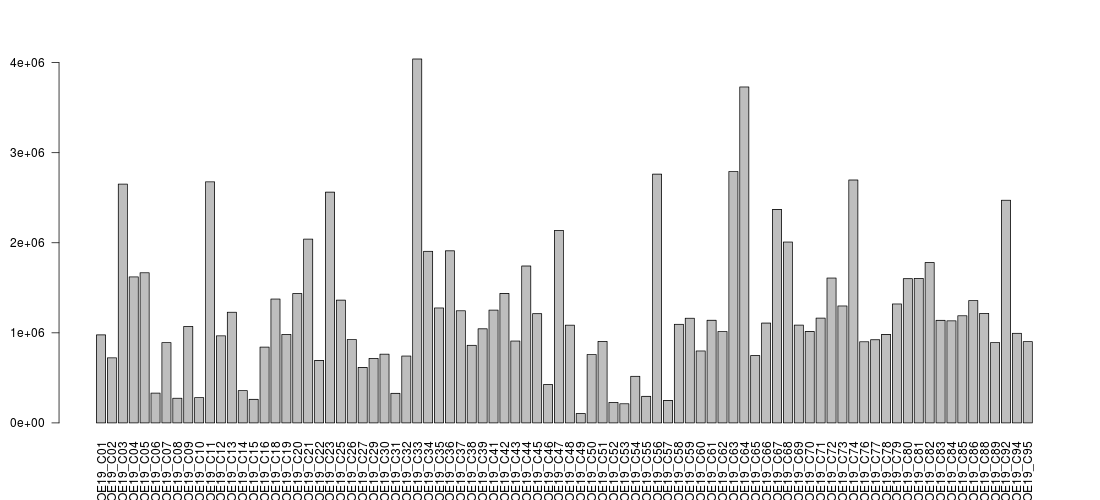

In [10]:
%%R -w 1100 -h 500
cellDepthMod <- read.table('/home/baker/Rna-seq_Data-Analysis/Ed_Britton_Single-Cell_ATAC_Seq/CellDepthMod.txt')
head(cellDepthMod)
barplot((cellDepthMod[,2]),names=cellDepthMod[,1], las=2)
#colnames(BinaryInformationModClusterJacard)
#cellDepthValid <- cellDepth[colnames(BinaryInformationModClusterJacard),]
#head(cellDepthValid)
#colnames(BinaryInformationModClusterJacard)

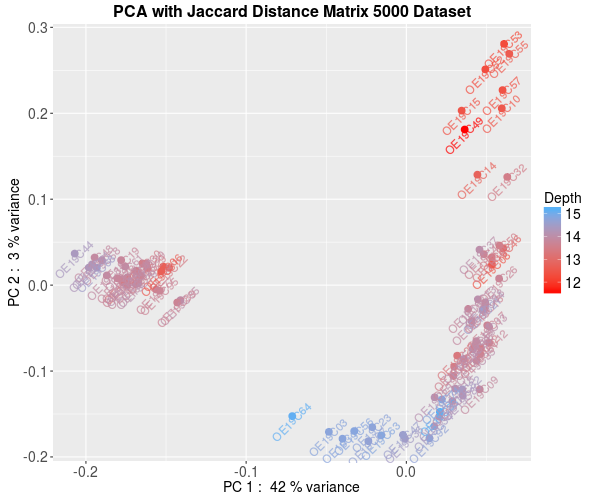

In [11]:
%%R -w 600 -h 500

#pdf("PCA with Jaccard Distance Matrix 5000 Dataset.pdf") # Used this function to save the file in pdf format
#png("PCA with Jaccard Distance Matrix 5000 Dataset.png") # Used this function to save the file in pdf format
#print(dim(ReadPCAData))
FinalPCAData <- BinaryInformationModClusterJacardSelected
#FinalPCAData <- na.omit(FinalPCAData)
#print(dim(FinalPCAData))
# strain <- factor(rownames(cellDepthMod), levels=rownames(cellDepthMod), labels=rownames(cellDepthMod))
Cell <- factor(colnames(BinaryInformationModClusterJacardSelected), levels=colnames(BinaryInformationModClusterJacardSelected), labels=colnames(BinaryInformationModClusterJacardSelected))
# depth <- factor(cellDepthMod[,2], levels=cellDepthMod[,2], labels=cellDepthMod[,2])
Depth <- log(cellDepthMod[,2])
PCx=1
PCy=2
pcaPRComp <- prcomp((FinalPCAData))
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$rotation[,PCx],PCY=pcaPRComp$rotation[,PCy], Cell=Cell, Depth=Depth)
p <- ggplot(df, aes_string(x="PCX",y ="PCY",color="Depth"))
p <- p + scale_colour_gradient(limits=c(min(Depth),max(Depth)), low='red')
p <- p + ggtitle("PCA with Jaccard Distance Matrix 5000 Dataset") + theme(plot.title = element_text(size = 16, face = "bold"))
p <- p + geom_point(size = 3)
p <- p + xlab(paste("PC",PCx,": ", ceiling(percentVar[PCx] * 100), "% variance")) 
p <- p + ylab(paste("PC",PCy,": ", ceiling(percentVar[PCy] * 100), "% variance"))
p <- p + theme(axis.title = element_text(size = 14), axis.text = element_text(size = 14), legend.text = element_text(size = 14), legend.title = element_text(size = 14))
p<-p + geom_text(data=df,aes(label=colnames(BinaryInformationModClusterJacardSelected)),alpha=0.7,size=4, vjust=1,hjust=0.6,angle=45)
print(p)

In [1]:
%%R
BinaryInformationModClusterJacardSelected

ERROR: Cell magic `%%R` not found.


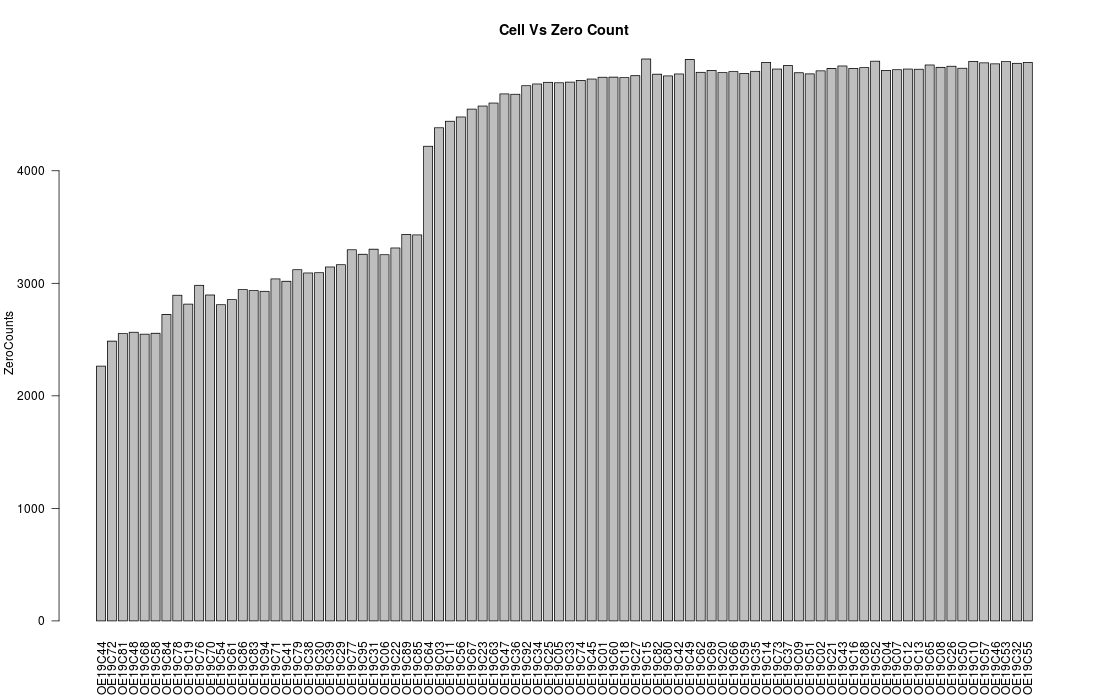

In [12]:
%%R -w 1100 -h 700
testdf <- data.frame(PCX=pcaPRComp$rotation[,PCx],PCY=pcaPRComp$rotation[,PCy], Cell=Cell, Depth=Depth, CellZeros=CellZeros )
testdf <- testdf[order(testdf[,1]),]
testdfForPlot <- data.frame(testdf$Cell, testdf$CellZeros)
barplot(testdf$CellZeros, main="Cell Vs Zero Count", ylab="ZeroCounts", names.arg=testdf$Cell, las=2) 

In [13]:
%%R
BinarySorted <-BinaryInformationModCluster[1:5000,rownames(testdf)]

In [15]:
%%R
write.csv(BinarySorted, 'BinarySortedForCluster.csv')

In [101]:
%%R
ZeroCountFirst <- rowSums(BinarySorted[,c(1:30)]==0)
ZeroCountSecond <- rowSums(BinarySorted[,c(31:dim(BinarySorted)[2])]==0)
OneCountFirst <- rowSums(BinarySorted[,c(1:30)]==1)
OneCountSecond <- rowSums(BinarySorted[,c(31:dim(BinarySorted)[2])]==1)
#BinarySorted[,c(30,31)]
ZeroCountFirst

   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
   0    1    0    0    0    0    0    0    2    0    0    1    1    0    0    2 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
   0    6    0    5    5    7    3    0    4    4    5    1    5    5    5    6 
  33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48 
   5    6    3    5    5    9    7    5    4    4    7    4    4    8    6    9 
  49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64 
   7    8    4    4   13   10    6    7    4    9   11    8   10   11    7    8 
  65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80 
   6   14    7   11    8    5    9    6    6    9    5    8   10   10   11    7 
  81   82   83   84   85   86   87   88   89   90   91   92   93   94   95   96 
   8    9   12    6    9    9    3   11    6   13    6    6   10    6    6    7 
  97   98   99  100  101  10

In [119]:
%%R
contingencyTable <- matrix(c(ZeroCountFirst[1], ZeroCountSecond[1], OneCountFirst[1], OneCountSecond[1]), ncol=2)
fisher.test(contingencyTable)


	Fisher's Exact Test for Count Data

data:  contingencyTable
p-value = 0.0007962
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.0000000 0.3862253
sample estimates:
odds ratio 
         0 



In [116]:
%%R
pvalue = vector(mode="numeric", length=5000)
for(i in 1:5000)
{
    contingencyTable <- matrix(c(ZeroCountFirst[i], ZeroCountSecond[i], OneCountFirst[i], OneCountSecond[i]), ncol=2)
    pvalue[i] <- fisher.test(contingencyTable)$p.value

}


In [135]:
%%R
BinaryInformationPvalue <- cbind(BinaryInformation[1:5000,c(1:3)],pvalue)
BinaryInformationPvalue <- BinaryInformationPvalue[order(BinaryInformationPvalue[,4]),]
write.csv(BinaryInformationPvalue, 'OE19BinaryInformationPvalue.csv')
head(BinaryInformationPvalue)

       Chr     Start       End       pvalue
200   chr3 197243425 197244025 1.109181e-15
557  chr11  67084886  67085486 4.306903e-15
144   chr4 120133410 120134010 1.085216e-14
1595  chr8  98861577  98862177 3.445523e-14
309   chr9  73034567  73035167 7.923625e-14
231  chr11 111174048 111174648 9.235915e-14


In [122]:
%%R
head(BinaryInformation)


Error in head(BinaryInformation) : object 'BinaryInformation' not found


/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Error in head(BinaryInformation) : object 'BinaryInformation' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [ ]:
BinaryInformationModCluster

In [18]:
%%R
MeanCountOE19 <- rowMeans(BinaryInformationModCluster)
NumZerosOE19 <- rowSums(BinaryInformationModCluster==0)
PercentZerosOE19 <- (NumZerosOE19/dim(BinaryInformationModCluster)[2])*100
ProbZeroOE19 <- exp(-(MeanCountOE19))

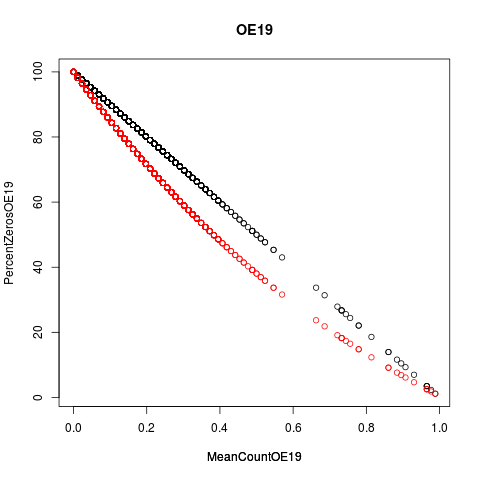

In [19]:
%%R
#png("OE19_Poisson_Zero.png")
plot(MeanCountOE19, PercentZerosOE19)
title("OE19")
par(new=T)
p3 = plot(MeanCountOE19, ProbZeroOE19*100, col='red', axes=F, ylab="")
par(new=F)

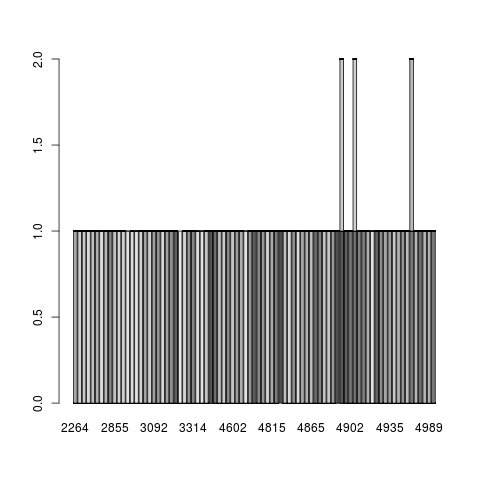

In [42]:
%%R
barplot(table(testdf$Cell, testdf$CellZeros))

In [169]:
%%R
DepthTest2 = as.matrix(Depth,ncol=2,nrow=86)
rownames(DepthTest2) <- colnames(BinaryInformationModClusterJacard)
DepthTest2

            [,1]
OE19C01 13.79252
OE19C02 13.49013
OE19C03 14.79068
OE19C04 14.29852
OE19C05 14.32638
OE19C06 12.70894
OE19C07 13.70047
OE19C08 12.51959
OE19C09 13.88391
OE19C10 12.54334
OE19C11 14.80005
OE19C12 13.78166
OE19C13 14.02152
OE19C14 12.78855
OE19C15 12.47453
OE19C16 13.64318
OE19C18 14.13415
OE19C19 13.79732
OE19C20 14.17757
OE19C21 14.52882
OE19C22 13.45012
OE19C23 14.75640
OE19C25 14.12522
OE19C26 13.73866
OE19C27 13.33116
OE19C29 13.48233
OE19C30 13.54527
OE19C31 12.70120
OE19C32 13.51738
OE19C33 15.21184
OE19C34 14.45998
OE19C35 14.05909
OE19C36 14.46306
OE19C37 14.03461
OE19C38 13.66642
OE19C39 13.85925
OE19C41 14.04040
OE19C42 14.17866
OE19C43 13.71974
OE19C44 14.37059
OE19C45 14.00832
OE19C46 12.96214
OE19C47 14.57487
OE19C48 13.89723
OE19C49 11.55186
OE19C50 13.54043
OE19C51 13.71564
OE19C52 12.33272
OE19C53 12.26471
OE19C54 13.15620
OE19C55 12.59453
OE19C56 14.83151
OE19C57 12.42768
OE19C58 13.90592
OE19C59 13.96563
OE19C60 13.59086
OE19C61 13.94607
OE19C62 13.830

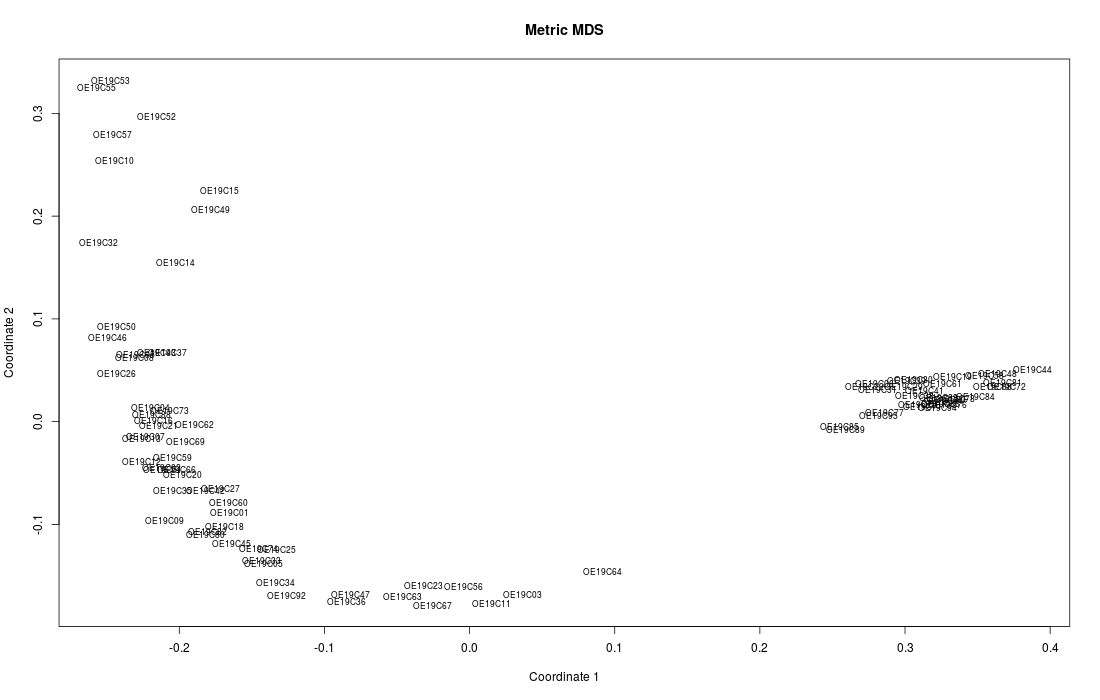

In [149]:
%%R -w 1100 -h 700
fit <- cmdscale(as.dist(BinaryInformationModClusterJacardSelected),eig=TRUE, k=2)
# fit # view results

# plot solution
x <- fit$points[,1]
y <- fit$points[,2]
plot(x, y, xlab="Coordinate 1", ylab="Coordinate 2",  main="Metric MDS", type="n")
text(x, y, labels = colnames(BinaryInformationModClusterJacard), cex=.7) 
#x <- loc[, 1]
#y <- -loc[, 2] # reflect so North is at the top
## note asp = 1, to ensure Euclidean distances are represented correctly
#plot(x, y, type = "n", xlab = "", ylab = "", asp = 1, axes = FALSE,
#     main = "cmdscale(eurodist)")
#text(x, y, rownames(loc), cex = 0.6)

In [ ]:
%%R
loc

In [ ]:
%%R
x <- matrix(rnorm(100), nrow = 10)
dist(x)

In [ ]:
%%R
as.dist(BinaryInformationModClusterJacard)

## Heterogeneity with HET1A

/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: HET1A_S1 Normal_Tissue_Aggregated  Normal_Aggregated Full-Media 1 macs

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: HET1A_S2 Normal_Tissue_Aggregated  Normal_Aggregated Full-Media 2 macs

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: HET1AC2 esophageal  Normal Full-Media 1 macs

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: HET1AC3 esophageal  Normal Full-Media 2 macs

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: HET1AC4 esophageal  Normal Full-Media 3 macs

  res = super(Function, self).__call__(*ne

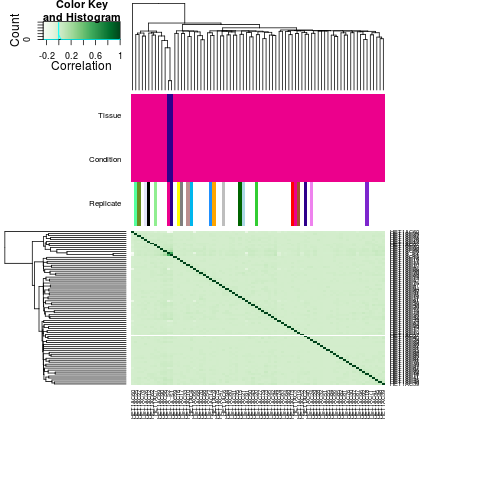

In [7]:
%%R
setwd('/home/baker/Rna-seq_Data-Analysis/Ed_Britton_Single-Cell_ATAC_Seq/')
samples <- read.csv("sampleSheetDiffBindAggregatedVsHET1A.csv")
HET1AAggregateVsSingleCell <- dba(sampleSheet = "sampleSheetDiffBindAggregatedVsHET1A.csv")
plot(HET1AAggregateVsSingleCell)

/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Re-centering peaks...

  res = super(Function, self).__call__(*new_args, **new_kwargs)


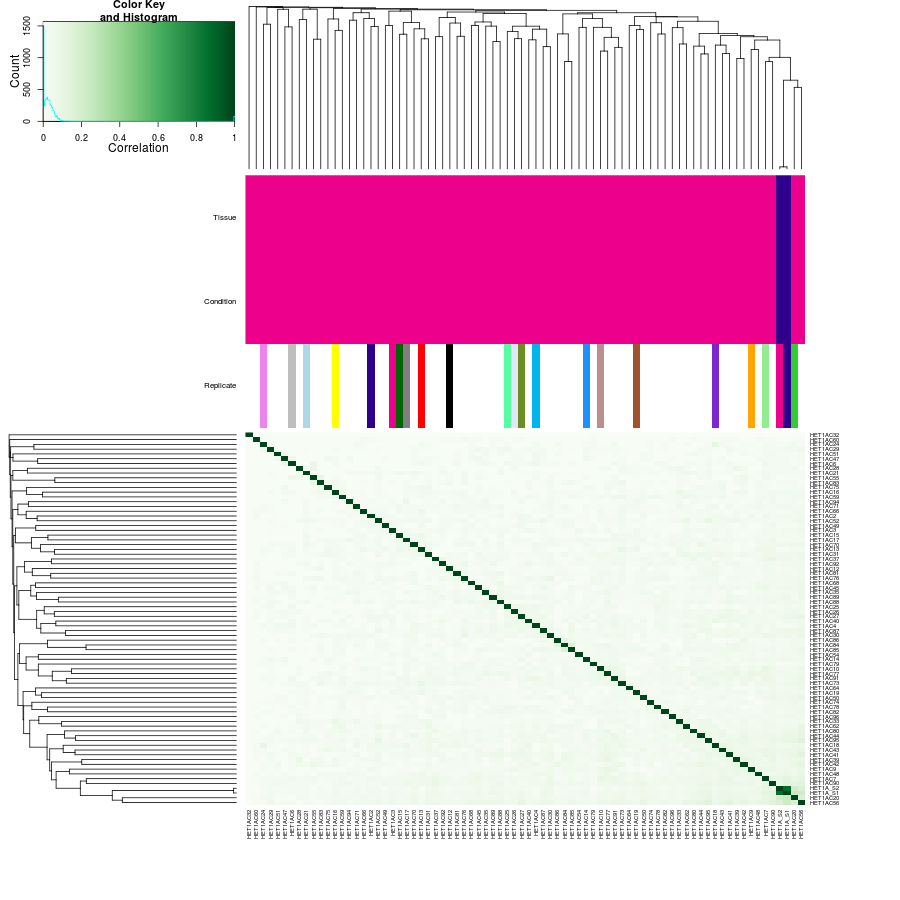

In [8]:
%%R -w 900 -h 900
HET1AAggregateVsSingleCell  <- dba.count(HET1AAggregateVsSingleCell , summits=300)
plot(HET1AAggregateVsSingleCell)

In [9]:
%%R -w 900 -h 900
HET1AAggregateVsSingleCell <- dba.contrast(HET1AAggregateVsSingleCell, group1 = HET1AAggregateVsSingleCell$masks$Normal_Tissue_Aggregated, group2 = HET1AAggregateVsSingleCell$masks$esophageal, name1 = "Normal_Tissue_Aggregated", name2 = "esophageal")

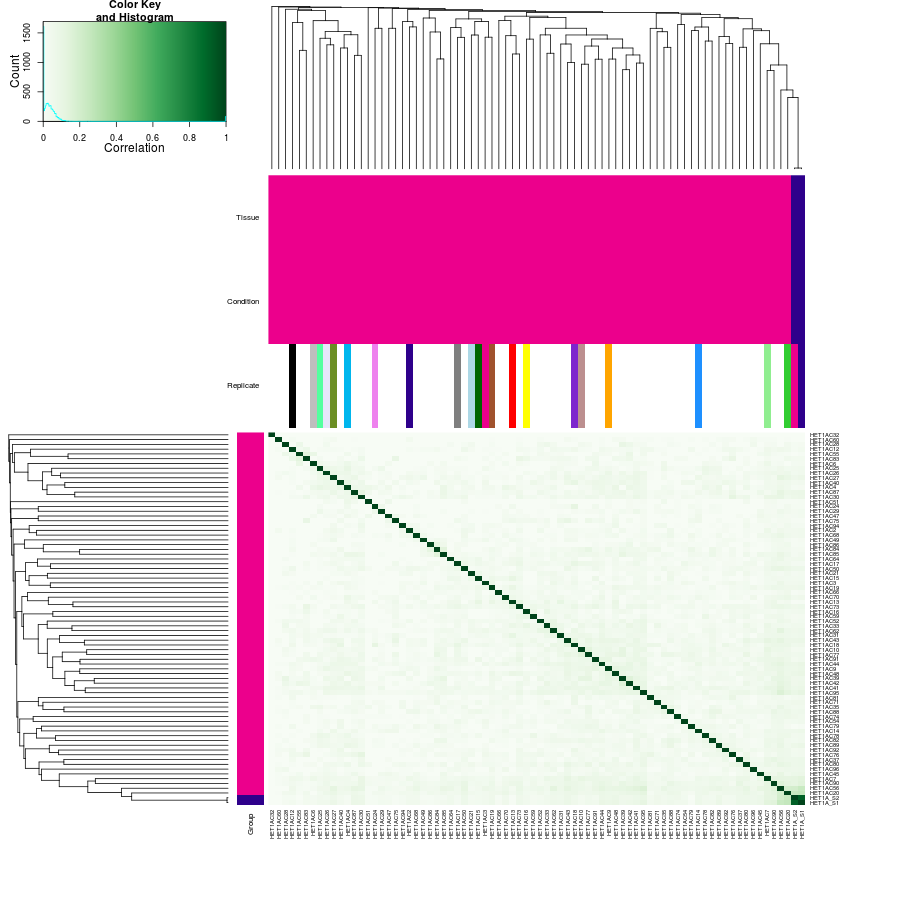

In [10]:
%%R -w 900 -h 900
HET1AAggregateVsSingleCell = dba.analyze(HET1AAggregateVsSingleCell)
plot(HET1AAggregateVsSingleCell, contrast=1)

In [11]:
%%R -w 900 -h 900
HET1AAggregateVsSingleCell.DB = dba.report(HET1AAggregateVsSingleCell, bCounts=TRUE)

In [12]:
%%R -w 900 -h 900
HET1AAggregateVsSingleCell.Avail = dba.report(HET1AAggregateVsSingleCell, bCalledDetail=TRUE, file='HET1ABinaryInformation.csv')

In [27]:
%%R
HET1ABinaryInformation <- read.csv('DBA_HET1ABinaryInformationModified.csv',header=TRUE)

In [47]:
%%R
dim(HET1ABinaryInformation)

[1] 12556    79


In [29]:
%%R
HET1ABinaryInformationMod <- as.matrix(HET1ABinaryInformation)
HET1ABinaryInformationMod <- replace(HET1ABinaryInformationMod,HET1ABinaryInformationMod=='+', 1)
HET1ABinaryInformationMod <- replace(HET1ABinaryInformationMod,HET1ABinaryInformationMod=='-', 0)
HET1ABinaryInformationMod <- data.frame(HET1ABinaryInformationMod)
head(HET1ABinaryInformationMod)
write.csv(HET1ABinaryInformationMod, 'HET1ABinaryInformation.csv')
HET1ABinaryInformation <- read.csv('HET1ABinaryInformation.csv', row.names=1)

In [30]:
%%R
#BinaryInformation[as.character(BinaryInformation$Chr) == 'chr17',4:5]
HET1AchrName <- as.character(unique(HET1ABinaryInformation$Chr))
HET1AchrSummary <- matrix(,nrow=length(HET1AchrName), ncol=length(4:dim(HET1ABinaryInformation)[2]))
for(i in 1:length(HET1AchrName))
{
    HET1AchrSummary[i,] <- colSums(HET1ABinaryInformation[as.character(HET1ABinaryInformation$Chr) == HET1AchrName[i],4:dim(HET1ABinaryInformation)[2]])
}
rownames(HET1AchrSummary)<-HET1AchrName
colnames(HET1AchrSummary) <- colnames(HET1ABinaryInformation[,4:dim(HET1ABinaryInformation)[2]])

In [33]:
%%R
HET1ABinaryInformationModCluster <- HET1ABinaryInformationMod[,4:dim(HET1ABinaryInformationMod)[2]]
dim(HET1ABinaryInformationModCluster)

[1] 12556    76


In [50]:
%%R
#write.csv(HET1ABinaryInformationModCluster,'HET1ABinaryInformationModCluster.csv')
HET1ABinaryInformationModCluster <- read.csv('HET1ABinaryInformationModCluster.csv', row.names=1)

In [51]:
%%R
dim(HET1ABinaryInformationModCluster)

[1] 12556    75


In [52]:
%%R
HET1ABinaryInformationModClusterJacard <- jaccard(as.matrix(HET1ABinaryInformationModCluster))

In [53]:
%%R
head(HET1ABinaryInformationModClusterJacard)

          HET1AC2   HET1AC3   HET1AC4   HET1AC6   HET1AC7   HET1AC9  HET1AC10
HET1AC2 0.0000000 1.0000000 1.0000000 1.0000000 0.9873817 1.0000000 1.0000000
HET1AC3 1.0000000 0.0000000 1.0000000 1.0000000 0.9938838 1.0000000 1.0000000
HET1AC4 1.0000000 1.0000000 0.0000000 1.0000000 0.9901316 1.0000000 0.9666667
HET1AC6 1.0000000 1.0000000 1.0000000 0.0000000 0.9966555 1.0000000 1.0000000
HET1AC7 0.9873817 0.9938838 0.9901316 0.9966555 0.0000000 0.9849398 0.9901639
HET1AC9 1.0000000 1.0000000 1.0000000 1.0000000 0.9849398 0.0000000 0.9833333
         HET1AC12  HET1AC13  HET1AC14  HET1AC15  HET1AC16  HET1AC17  HET1AC18
HET1AC2 0.9787234 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 0.9807692
HET1AC3 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
HET1AC4 1.0000000 0.9677419 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
HET1AC6 1.0000000 1.0000000 1.0000000 1.0000000 0.9855072 1.0000000 0.9677419
HET1AC7 0.9869707 0.9934853 0.9889503 0.9933775 0.9943182 0.9935

In [54]:
%%R
(as.dist(HET1ABinaryInformationModClusterJacard))

           HET1AC2   HET1AC3   HET1AC4   HET1AC6   HET1AC7   HET1AC9  HET1AC10
HET1AC3  1.0000000                                                            
HET1AC4  1.0000000 1.0000000                                                  
HET1AC6  1.0000000 1.0000000 1.0000000                                        
HET1AC7  0.9873817 0.9938838 0.9901316 0.9966555                              
HET1AC9  1.0000000 1.0000000 1.0000000 1.0000000 0.9849398                    
HET1AC10 1.0000000 1.0000000 0.9666667 1.0000000 0.9901639 0.9833333          
HET1AC12 0.9787234 1.0000000 1.0000000 1.0000000 0.9869707 1.0000000 1.0000000
HET1AC13 1.0000000 1.0000000 0.9677419 1.0000000 0.9934853 1.0000000 1.0000000
HET1AC14 1.0000000 1.0000000 1.0000000 1.0000000 0.9889503 0.9741379 0.9887640
HET1AC15 1.0000000 1.0000000 1.0000000 1.0000000 0.9933775 1.0000000 1.0000000
HET1AC16 1.0000000 1.0000000 1.0000000 0.9855072 0.9943182 1.0000000 1.0000000
HET1AC17 1.0000000 1.0000000 1.0000000 1.0000000 0.9

[1] "Data (original) range:  0 1"
[1] "Data (scale) range:  -8.54 0.23"
[1] "Data scaled to range:  -3 0.23"


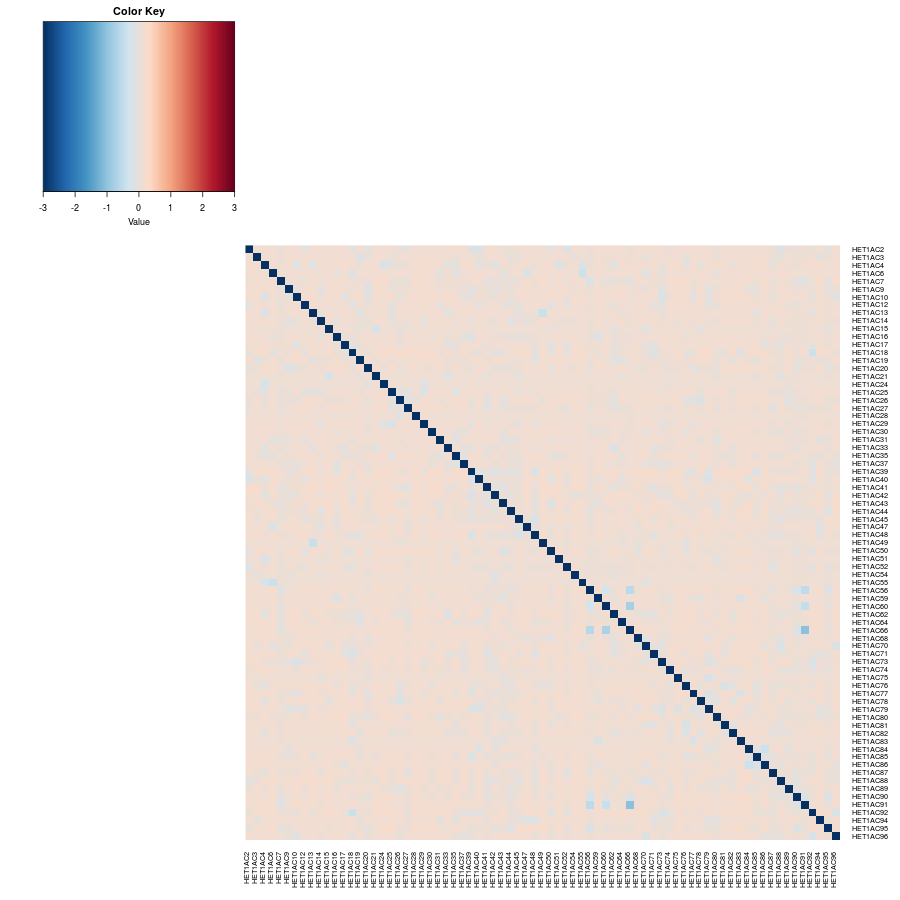

In [55]:
%%R -w 900 -h 900
heatplot(HET1ABinaryInformationModClusterJacard, distfun=NULL, scale="none", dend="none")

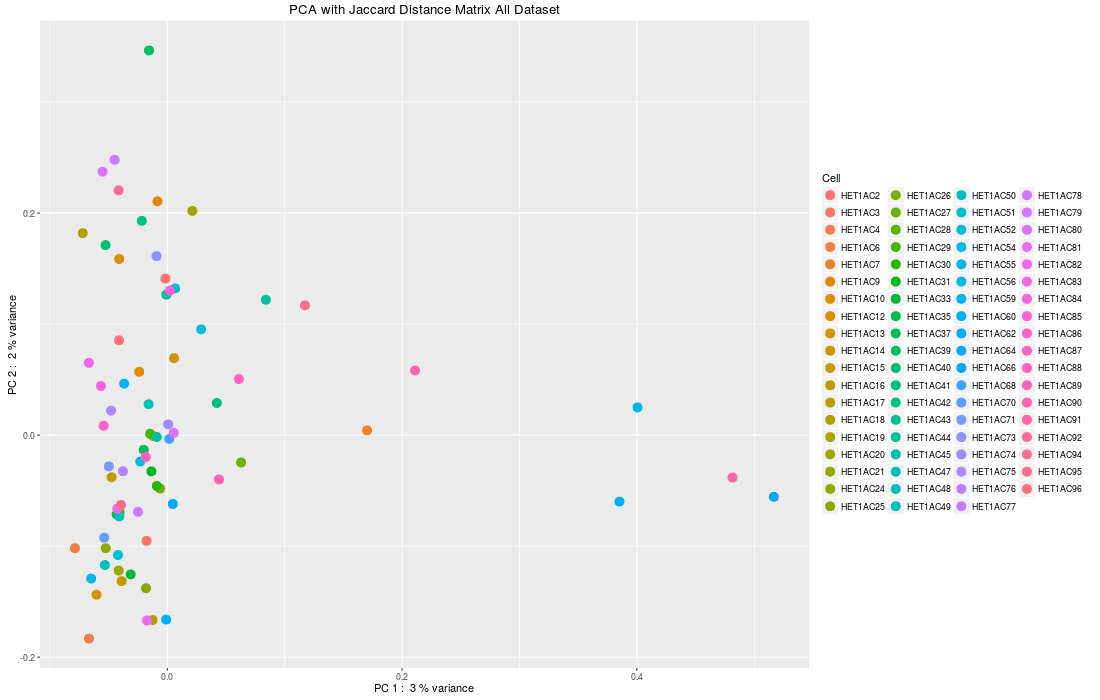

In [56]:
%%R -w 1100 -h 700
#pdf("PCA with Jaccard Distance Matrix All Dataset.pdf") # Used this function to save the file in pdf format
#print(dim(ReadPCAData))
FinalPCAData <- HET1ABinaryInformationModClusterJacard
#FinalPCAData <- na.omit(FinalPCAData)
#print(dim(FinalPCAData))
strain <- factor(colnames(HET1ABinaryInformationModCluster), levels=colnames(HET1ABinaryInformationModCluster), labels=colnames(HET1ABinaryInformationModCluster))
PCx=1
PCy=2
pcaPRComp <- prcomp((FinalPCAData))
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$rotation[,PCx],PCY=pcaPRComp$rotation[,PCy], Cell=strain)
p<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p<-p+ggtitle("PCA with Jaccard Distance Matrix All Dataset")
p<-p+geom_point(size = 4)
p<-p+xlab(paste("PC",PCx,": ", ceiling(percentVar[PCx] * 100), "% variance"))
p<-p    + ylab(paste("PC",PCy,": ", ceiling(percentVar[PCy] * 100), "% variance"))
#p<-p + geom_text(data=df,aes(label=colnames(HET1ABinaryInformationModClusterJacard)),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45)
print(p)

In [57]:
%%R
HET1ABinaryInformationModClusterJacardSelected <- jaccard(as.matrix(HET1ABinaryInformationModCluster[1:5000,]))
CellZeros <- colSums(as.matrix(HET1ABinaryInformationModCluster[1:5000,]) == 0)

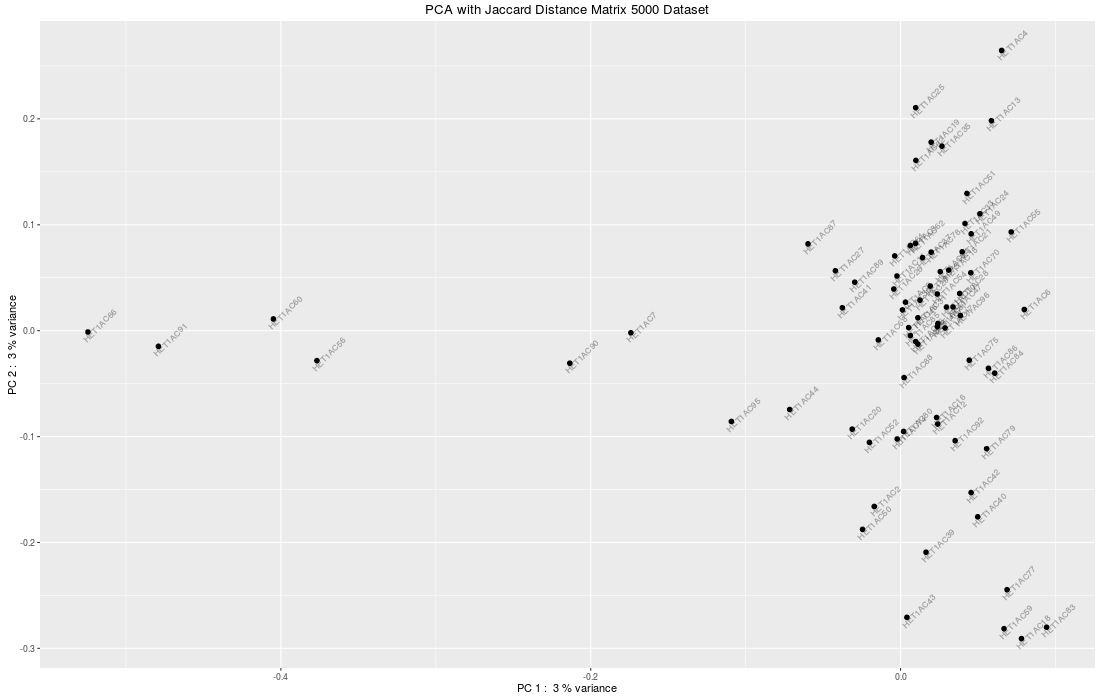

In [58]:
%%R -w 1100 -h 700

#pdf("PCA with Jaccard Distance Matrix 5000 Dataset.pdf") # Used this function to save the file in pdf format
#png("PCA with Jaccard Distance Matrix 5000 Dataset.png") # Used this function to save the file in pdf format
#print(dim(ReadPCAData))
FinalPCAData <- HET1ABinaryInformationModClusterJacardSelected
#FinalPCAData <- na.omit(FinalPCAData)
#print(dim(FinalPCAData))
strain <- factor(colnames(HET1ABinaryInformationModCluster), levels=colnames(HET1ABinaryInformationModCluster), labels=colnames(HET1ABinaryInformationModCluster))
PCx=1
PCy=2
pcaPRComp <- prcomp((FinalPCAData))
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$rotation[,PCx],PCY=pcaPRComp$rotation[,PCy], Cell=strain)
p<-ggplot(df, aes_string(x="PCX",y ="PCY"))
p<-p+ggtitle("PCA with Jaccard Distance Matrix 5000 Dataset")
p<-p+geom_point(size = 2)
p<-p+xlab(paste("PC",PCx,": ", ceiling(percentVar[PCx] * 100), "% variance"))
p<-p    + ylab(paste("PC",PCy,": ", ceiling(percentVar[PCy] * 100), "% variance"))
p<-p + geom_text(data=df,aes(label=colnames(HET1ABinaryInformationModClusterJacard)),alpha=0.3,size=3, vjust=1,hjust=0.2,angle=45)
print(p)


In [45]:
%%R
HET1ABinaryInformationModClusterJacardSelected

           HET1AC2   HET1AC3   HET1AC4   HET1AC6   HET1AC7   HET1AC9  HET1AC10
HET1AC2  0.0000000 1.0000000 1.0000000 1.0000000 0.9800000 1.0000000 1.0000000
HET1AC3  1.0000000 0.0000000 1.0000000 1.0000000 0.9950000 1.0000000 1.0000000
HET1AC4  1.0000000 1.0000000 0.0000000 1.0000000 0.9841270 1.0000000 1.0000000
HET1AC6  1.0000000 1.0000000 1.0000000 0.0000000 0.9946524 1.0000000 1.0000000
HET1AC7  0.9800000 0.9950000 0.9841270 0.9946524 0.0000000 0.9801980 0.9893048
HET1AC9  1.0000000 1.0000000 1.0000000 1.0000000 0.9801980 0.0000000 1.0000000
HET1AC10 1.0000000 1.0000000 1.0000000 1.0000000 0.9893048 1.0000000 0.0000000
HET1AC12 0.9722222 1.0000000 1.0000000 1.0000000 0.9843750 1.0000000 1.0000000
HET1AC13 1.0000000 1.0000000 0.9500000 1.0000000 0.9894180 1.0000000 1.0000000
HET1AC14 1.0000000 1.0000000 1.0000000 1.0000000 0.9908257 0.9841270 1.0000000
HET1AC15 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
HET1AC16 1.0000000 1.0000000 1.0000000 0.9761905 0.9

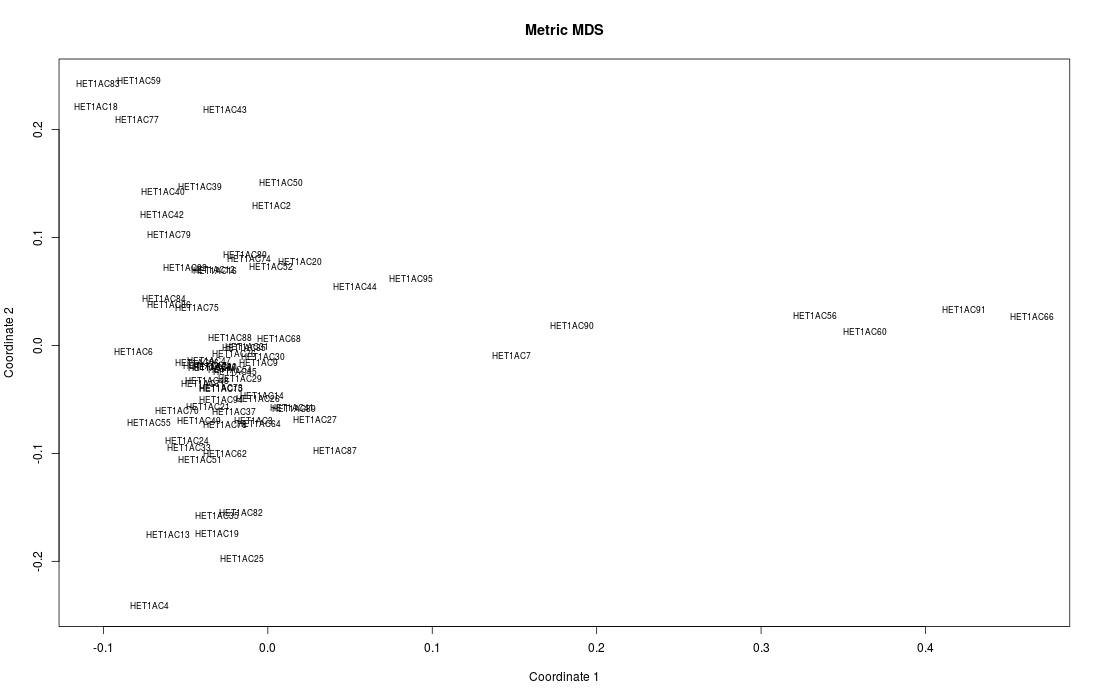

In [59]:
%%R -w 1100 -h 700
fit <- cmdscale(as.dist(HET1ABinaryInformationModClusterJacardSelected),eig=TRUE, k=2)
# fit # view results

# plot solution
x <- fit$points[,1]
y <- fit$points[,2]
plot(x, y, xlab="Coordinate 1", ylab="Coordinate 2",  main="Metric MDS", type="n")
text(x, y, labels = colnames(HET1ABinaryInformationModClusterJacardSelected), cex=.7) 
#x <- loc[, 1]
#y <- -loc[, 2] # reflect so North is at the top
## note asp = 1, to ensure Euclidean distances are represented correctly
#plot(x, y, type = "n", xlab = "", ylab = "", asp = 1, axes = FALSE,
#     main = "cmdscale(eurodist)")
#text(x, y, rownames(loc), cex = 0.6)

## Combined PCA

In [140]:
%%R
CombinedData <- c(HET1ABinaryInformationModClusterJacardSelected, BinaryInformationModClusterJacardSelected)
#print(dim(HET1ABinaryInformationModClusterJacardSelected))
#print(dim(BinaryInformationModClusterJacardSelected))
print(dim(CombinedData))

NULL


In [ ]:
%%R -w 600 -h 600
FinalPCAData <- AllData 
# # Used this function to save the file in pdf format
#FinalPCAData <- na.omit(FinalPCAData)
#print(dim(FinalPCAData))
sampleCondition <- c(rep("All",96),rep("Half",96),rep("Fourth",96),rep("Sixth",96), rep("Tenth",96), rep("Hundred",96))
strain <- factor(sampleCondition, levels=c("All", "Half", "Fourth", "Sixth", "Tenth","Hundred"),labels=c("All", "Half", "Fourth", "Sixth", "Tenth","Hundred"))
PCx=1
PCy=2
pcaPRComp <- prcomp((FinalPCAData))
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$rotation[,PCx],PCY=pcaPRComp$rotation[,PCy],Cell=strain)
p<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p<-p+ggtitle("PCA with Normalized Dataset")
p<-p+geom_point(size = 2)
p<-p+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p<-p    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
#p<-p + geom_text(data=df,aes(label=colnames(cd)),alpha=0.5,size=5, vjust=1,hjust=0.5,angle=45, color="black")
print(p)

## DE peaks between HET1A and OE19

We now look at the differentially accessible peaks found in OE19 cells. If using those alone, is there a single population or are there still different populations in the PCA plot. The question there really relates to whether there is something other than the "common cancer peaks" that is driving the heterogeneity. Are the "cancer common peaks" homogenous across cells?

## DE for the cells identified above

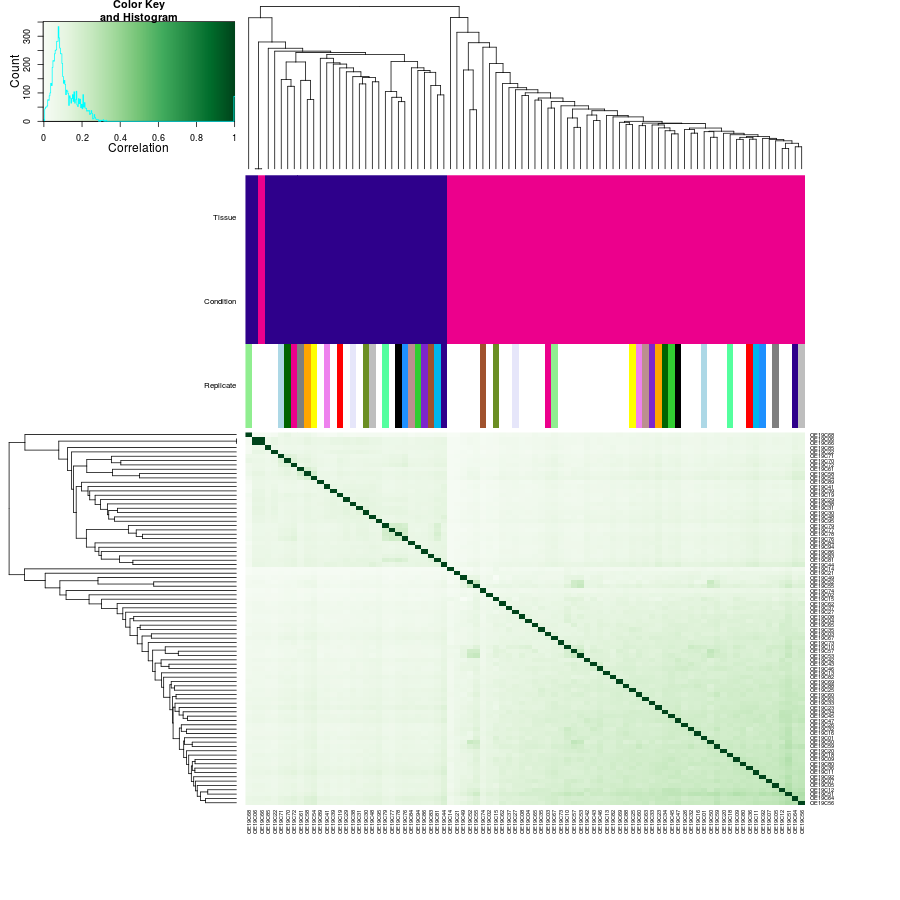

In [67]:
%%R -w 900 -h 900
setwd('/home/baker/Rna-seq_Data-Analysis/Ed_Britton_Single-Cell_ATAC_Seq/')
samples <- read.csv("sampleSheetDiffBindOE19Clusters.csv")
OE19SingleCellCluster <- dba(sampleSheet = "sampleSheetDiffBindOE19Clusters.csv")
plot(OE19SingleCellCluster)

/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Re-centering peaks...

  res = super(Function, self).__call__(*new_args, **new_kwargs)


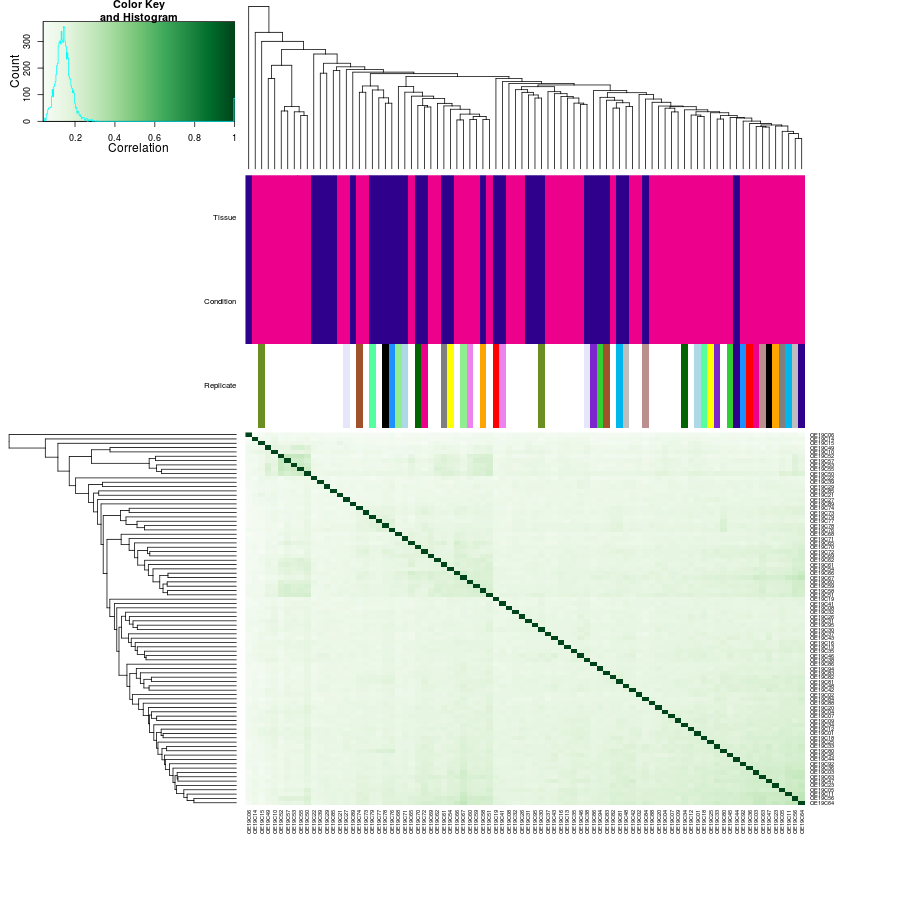

In [72]:
%%R -w 900 -h 900
OE19SingleCellCluster  <- dba.count(OE19SingleCellCluster , summits=300)
plot(OE19SingleCellCluster)

In [78]:
%%R
#OE19SingleCellCluster <- dba.contrast(OE19SingleCellCluster, group1 = OE19SingleCellCluster$masks$Cancer_High, group2 = OE19SingleCellCluster$masks$Cancer_Low, name1 = "Cancer_High", name2 = "Cancer_Low")
OE19SingleCellCluster <- dba.contrast(OE19SingleCellCluster, categories=DBA_CONDITION)

In [79]:
%%R -w 900 -h 900
OE19SingleCellCluster = dba.analyze(OE19SingleCellCluster)
#plot(OE19SingleCellCluster, contrast=1)

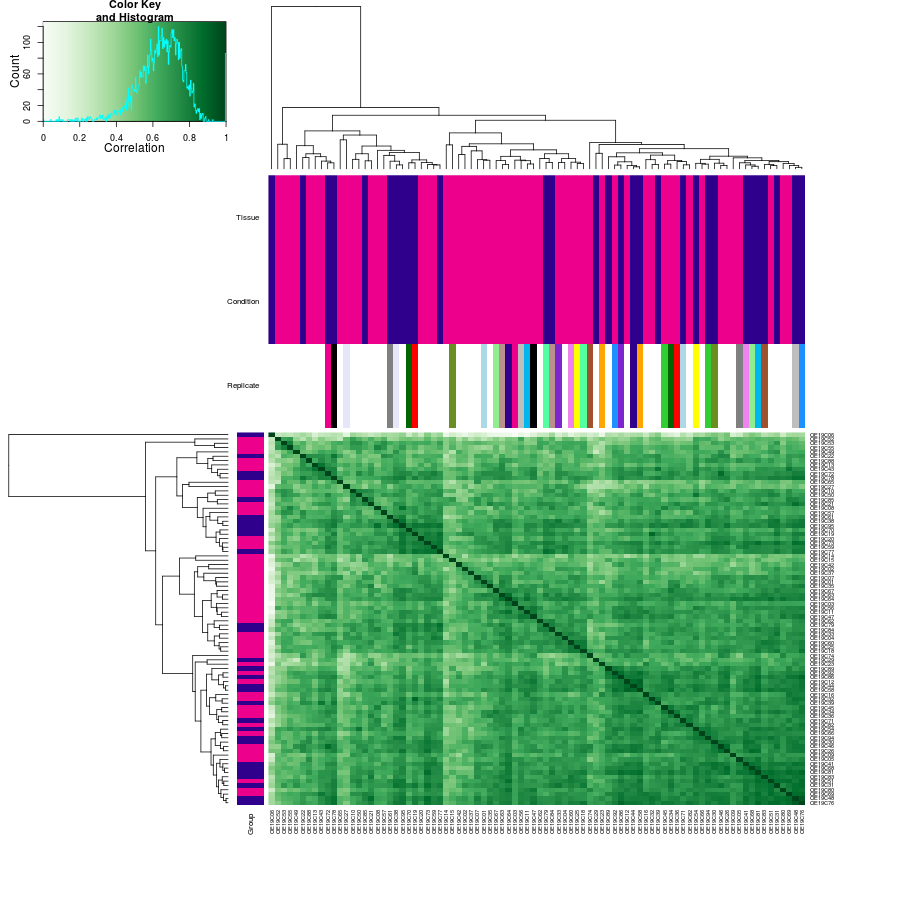

In [80]:
%%R -w 900 -h 900
plot(OE19SingleCellCluster, contrast=1)

In [81]:
%%R -w 900 -h 900
OE19SingleCellCluster.DB = dba.report(OE19SingleCellCluster, bCounts=TRUE)

In [82]:
%%R
OE19SingleCellCluster.DB

GRanges object with 37 ranges and 92 metadata columns:
        seqnames                 ranges strand   |              Conc
           <Rle>              <IRanges>  <Rle>   |         <numeric>
  19562    chr17   [39810244, 39810844]      *   |  4.94605620016516
  19451    chr17   [37842736, 37844534]      *   |  3.75861058820619
  48868     chr9   [91612451, 91618802]      *   | 0.840521785992804
  19620    chr17   [39942870, 39943470]      *   |  4.74052599601608
   9596    chr11   [82867567, 82868167]      *   |   1.9915877601838
    ...      ...                    ...    ... ...               ...
  32711     chr3 [119813052, 119814151]      *   |  1.06558834162758
  42246     chr7 [ 25901853,  25902453]      *   |  1.82640067774815
   9042    chr11 [ 67396597,  67398495]      *   |  1.32192809488736
  39489     chr6 [ 42951916,  42952516]      *   |  1.16619228256598
  22637    chr19 [ 30335087,  30336304]      *   |  1.02494635713023
         Conc_Cancer_High      Conc_Cancer_Low  

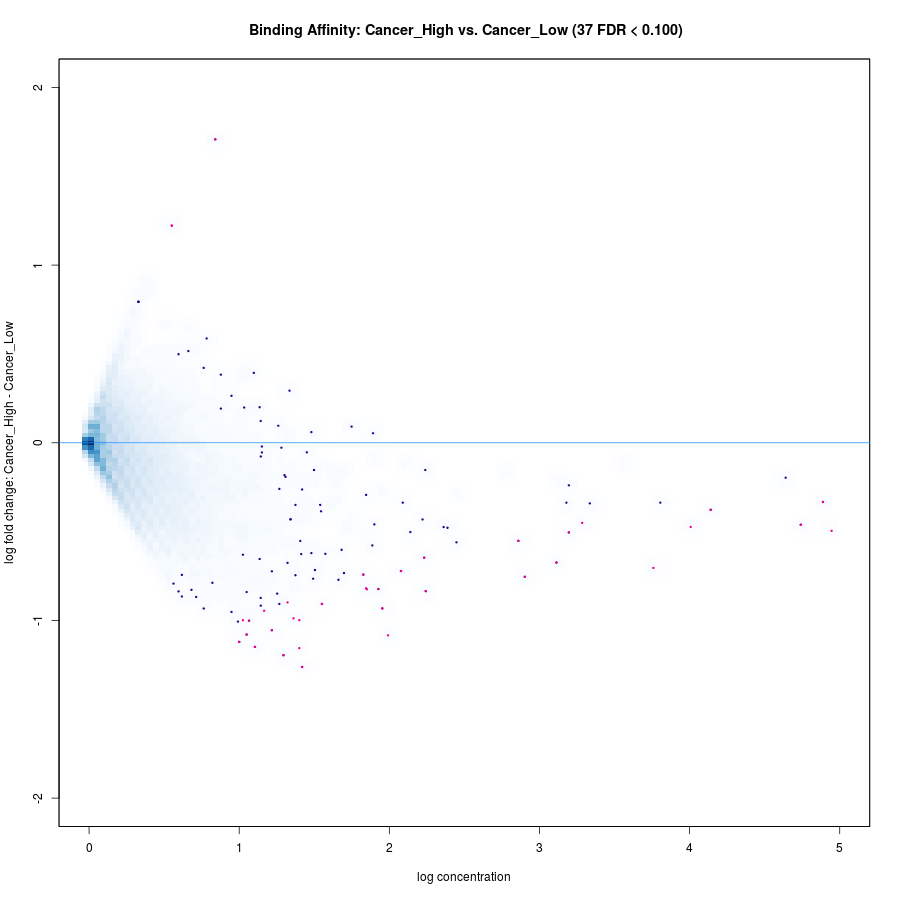

In [83]:
%%R -w 900 -h 900
dba.plotMA(OE19SingleCellCluster)

In [87]:
%%R -w 900 -h 900
dba.plotPCA(OE19SingleCellCluster, contrast=1, DBA_CONDITION, label=DBA_ID)

## Applying Panos's LCAVS

In [23]:
%%R
library(BayesBinMix)

In [26]:
%%R
head(BinaryInformationModClusterJacardSelected)

          OE19C01   OE19C02   OE19C03   OE19C04   OE19C05   OE19C06   OE19C07
OE19C01 0.0000000 0.9192308 0.9364865 0.9305019 0.9005682 0.9512596 0.9072581
OE19C02 0.9192308 0.0000000 0.9450867 0.8944724 0.9144737 0.9694953 0.9081633
OE19C03 0.9364865 0.9450867 0.0000000 0.9385965 0.9043250 0.8838527 0.9458272
OE19C04 0.9305019 0.8944724 0.9385965 0.0000000 0.9096990 0.9642458 0.8770053
OE19C05 0.9005682 0.9144737 0.9043250 0.9096990 0.0000000 0.9412399 0.9003436
OE19C06 0.9512596 0.9694953 0.8838527 0.9642458 0.9412399 0.0000000 0.9727626
          OE19C08   OE19C09   OE19C10   OE19C11   OE19C12   OE19C13   OE19C14
OE19C01 0.9130435 0.9003690 0.9351351 0.9167905 0.9004149 0.9057377 0.9543147
OE19C02 0.8779070 0.8790698 0.9312977 0.9400631 0.9109948 0.9062500 0.9507042
OE19C03 0.9582712 0.9205202 0.9810726 0.8716475 0.9359165 0.9532164 0.9765625
OE19C04 0.8882353 0.8925234 0.8943089 0.9430380 0.8913043 0.8924731 0.9416058
OE19C05 0.9166667 0.8878205 0.9396552 0.9164345 0.9134948 0.8989

In [ ]:
%%R

nChains <- 10
heats <- seq(1,0.4,length = nChains)
# NOTE: only m = 5 iterations are used here (modify to m = 1000 for non-erroneous results)
coupledMetropolis(Kmax = 5,nChains = nChains,heats =  heats,binaryData = as.matrix(BinaryInformationModCluster[1:5000,]),outPrefix ='BayesBinMixExample',ClusterPrior ='poisson',m = 500)


In [ ]:
%%R
write.csv(data.matrix(BinaryInformationModCluster[1:500,1:10]), 'BinaryInformationModClusterSelected.csv', sep='\t')

In [ ]:
%%R
sink()

In [ ]:
%%R
testBinary <- read.csv('BinaryInformationModCluster.csv', row.names=1)

In [ ]:
%%R
head(testBinary)

In [ ]:
%%R
head(testBinary)

In [ ]:
%%R
range(testBinary)